## Fly Bowl Walking Kinematic Analysis  
#### Code for analyzing fly bowl data to compare walking in different set-ups (linear treadmill, spherical treadmill, fly bowl).
#### Based off of sleap tracking data.
#### Su-Yee J. Lee 05/10/23 

# to do: add a continuous step filter 
# get rid of edge effects - only capture when whole body is in frame, so cut off ends of walking bouts... 

In [1]:
# access folder with data files (.h5 files of sleap tracked videos) 
import os 
filePath = '/Users/leesuyee/Library/CloudStorage/GoogleDrive-suyeejoy@tuthill.casa/My Drive/Tuthill Lab Shared/SuYee/fly bowl/2023/wtberlin_multianimal/'
os.chdir(filePath)

In [ ]:
cd /Users/leesuyee/Desktop/walking_intermediate


In [2]:
# import python libraries
import h5py
import glob
import os
import math
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal
import fnmatch as fn 
import read_data as rd
import organize_data as od
import filled as fl 
import align as al 
import velocity as vel 
import time_align as ta 
from scipy import signal
import compute_tcs as comp_tcs 
import swing_stance_classification as ssc
import estimate_BL as BL 
import compute_swing_distance as swing_dist
import compute_step_distance as step_dist
import swing_stance_duration_vel_based as swing_stance_v
import compute_step_freq_vel as comp_sf_v
import compute_AEP_PEP as comp_AP
import relative_phase_distance as rpd

In [23]:
# Iterate through videos, group data together, calculate velocity, step metrics, 
# tripod coordination strength, save as genotype_name.npy 

# open current directory 
cur_dir = os.getcwd() 
filenames = sorted(os.listdir(cur_dir))

# initialize some variables
h5_filename = [] 
filtered_filename = []
global_variables = []


# define some variables 
genotype = '*wtberlin*'#'*Ms*' # genotype / cohort name to query directory for 
genotype_name = 'wtberlin_v6'#'Ms'# save name "genotype_name.npy"
FPS = 150 
trial_samples = 1500 
nlegs = 6 
save = 1 # change to 1 to save group data 

# find all .h5 files with tracked SLEAP data 
for file in range(len(filenames)):
    if filenames[file][-3::] =='.h5':
        h5_filename.append(filenames[file])  
        
# search files for genotype / cohort of interest         
for aa in range(0, len(h5_filename)): #[0]:   
    if fn.fnmatch(h5_filename[aa], genotype):
        filtered_filename.append(h5_filename[aa])

median_BL_store = [] 

# iterate through each tracked video file 
for j in range(len(filtered_filename)): #[0]:   
    curr_file = filtered_filename[j]
    print(curr_file)
    [data, valid_frame_idxs, tracks, numflies] = rd.read_data(curr_file)
    headers = tracks.columns.tolist() #list headers 
    fly_dataframes = []
    fly_distributions = [] 

# reorganize data for each fly 
    for fly in range(0, len(numflies)): 
        curfly = numflies[fly]
        print(curfly)
        fly_df = tracks[ tracks[ headers[0] ] == curfly ]
        fly_dataframes.append(fly_df)
        [frame_idx, raw_positions] = od.organize_data(fly_df)
        [x_pos, y_pos, body_pos] = fl.filled(raw_positions) # separate leg positions from body positions (head, abdomen, thorax)
        [heading_angle, rot_vel, x_pos_egocentric, y_pos_egocentric, rot_head_egocentric, rot_abdomen_egocentric]=al.align(x_pos, y_pos, body_pos) # reorient positions to common heading angle, normalized to thorax (egocentric)
        [time_align_x_pos, time_align_y_pos, time_align_body_pos] = ta.time_align(frame_idx, x_pos_egocentric, y_pos_egocentric, rot_head_egocentric, body_pos[2], body_pos[3], rot_abdomen_egocentric) # time align all positions
        median_BL = BL.estimate_BL(body_pos) 
        median_BL_store.append(median_BL)

        
        # initialize some variables 
        velocity = [] 
        stance_start = [] 
        stance_end = [] 
        swing_stance_mat = [] 
        swing_distance = [] 
        step_distance = [] 
        stance_duration = [] 
        swing_duration = [] 
        duty_factor = []
        step_freq = []
        tcs_frames = []
        tcs_value = []
        tcs = [] 
        AEPx = [] 
        AEPy = []
        PEPx = [] 
        PEPy = [] 
        AEP_PEP = []
        step_phase = [] 
        relative_distance = [] 
        
        if len(body_pos[2]) >= 5: # only look at tracks >230 frames (~1.5s)
            filt_vel = vel.velocity(body_pos[2], body_pos[3], FPS, 5, median_BL) # calculate velocity using thorax position 
            [step_freq, stance_duration, swing_duration] = upsample_kinematics(time_align_x_pos, time_align_y_pos, FPS, nlegs, trial_samples)
            [swing_stance_mat, stance_start, stance_end] = ssc.swing_stance_classification(time_align_x_pos, time_align_y_pos, FPS, nlegs, trial_samples) #compute stance start/end, also filters out edges 
            swing_distance = swing_dist.compute_swing_distance(stance_start, stance_end, time_align_x_pos, time_align_y_pos, median_BL, nlegs, trial_samples) 
            step_distance = step_dist.compute_step_distance(time_align_x_pos, time_align_y_pos,stance_start, stance_end, median_BL, FPS, nlegs, trial_samples)
#             [stance_duration, swing_duration, duty_factor] = swing_stance_v.swing_stance_duration_vel_based(stance_start, stance_end, nlegs, trial_samples, FPS) 
#             step_freq = comp_sf_v.compute_step_freq_vel(stance_start, nlegs, trial_samples, FPS)
            tcs = comp_tcs.compute_tcs(stance_start, stance_end, FPS)
            [AEPx, AEPy, PEPx, PEPy] = comp_AP.compute_AEP_PEP(time_align_x_pos, time_align_y_pos, stance_start, stance_end, median_BL, nlegs, trial_samples)
            AEP_PEP.append(AEPx)
            AEP_PEP.append(AEPy)
            AEP_PEP.append(PEPx)
            AEP_PEP.append(PEPy)
            [step_phase, relative_distance] = rpd.relative_phase_distance(stance_start, time_align_x_pos, time_align_y_pos, trial_samples)

            
            # append each fly's 14 calculated variables (14 x num_flies) 
            fly_distributions.append(curr_file)
            fly_distributions.append(frame_idx)
            fly_distributions.append(time_align_x_pos)
            fly_distributions.append(time_align_y_pos) 
            fly_distributions.append(filt_vel)
            fly_distributions.append(swing_stance_mat)
            fly_distributions.append(swing_distance)
            fly_distributions.append(step_distance)
            fly_distributions.append(swing_duration)
            fly_distributions.append(stance_duration)
            fly_distributions.append(heading_angle)
            fly_distributions.append(rot_vel)
            fly_distributions.append(step_freq)
            fly_distributions.append(tcs)  
            fly_distributions.append(AEP_PEP)
            fly_distributions.append(step_phase)
            fly_distributions.append(relative_distance)

            
        else: 
            filt_vel = np.nan
            swing_stance_mat = np.nan
            swing_distance = np.nan
            step_distance = np.nan
            swing_duration = np.nan
            stance_duration = np.nan
            heading_angle = np.nan
            rot_vel = np.nan
            step_freq = np.nan
            tcs = np.nan
            AEP_PEP = np.nan 
            step_phase = np.nan
            relative_distance = np.nan
            
            # append each fly's 14 calculated variables (17 x num_flies) 
            fly_distributions.append(curr_file)
            fly_distributions.append(frame_idx)
            fly_distributions.append(time_align_x_pos)
            fly_distributions.append(time_align_y_pos) 
            fly_distributions.append(filt_vel)
            fly_distributions.append(swing_stance_mat)
            fly_distributions.append(swing_distance)
            fly_distributions.append(step_distance)
            fly_distributions.append(swing_duration)
            fly_distributions.append(stance_duration)
            fly_distributions.append(heading_angle)
            fly_distributions.append(rot_vel)
            fly_distributions.append(step_freq)
            fly_distributions.append(tcs)  
            fly_distributions.append(AEP_PEP)
            fly_distributions.append(step_phase)
            fly_distributions.append(relative_distance)
            
            
    global_variables.append(fly_distributions) # append each file's fly data 

# save grouped data as "genotype_name.npy"
    # global_variables[video][17 x num_flies]
if save == 1:
    global_variables_name = genotype_name
    np.save(global_variables_name, global_variables)
    np.save('median_BL_store.npy', median_BL_store)

genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m10_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m10_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'i

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (10, 1500)
point_scores: float64 array of shape (10, 11, 1500)
track_occupancy: bool array of shape (1500, 10)
tracking_scores: float64 array of shape (10, 1500)
tracks: float64 array of shape (1500, 11, 2, 10)
video_path: b'genotype_wtberlin_m10_trail_type_walk_session_1_repeat_4Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
track_5
track_6
track_7
track_8
track_9
genotype_wtberlin_m11_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m11_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_s

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m11_trail_type_walk_session_1_repeat_4Camera1.mp4'
track_0
genotype_wtberlin_m12_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m12_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of sh

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_2
track_3
track_4
genotype_wtberlin_m13_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m13_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m13_trail_type_nostim_session_1_repeat_1Camera1.mp4'
track_0
track_1
genotype_wtberlin_m13_trail_type_nostim_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m13_trail_type_nostim_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['ed

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_1
track_2
track_3
track_4
track_5
track_6
track_7
track_8
track_9
track_10
genotype_wtberlin_m13_trail_type_walk_session_2_repeat_3Camera1.mp4.000_genotype_wtberlin_m13_trail_type_walk_session_2_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m13_trail_type_walk_session_2_repeat_3Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m14_trail_type_walk_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m14_trail_type_walk_session_1_

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m14_trail_type_walk_session_1_repeat_1Camera1.mp4'
track_0
genotype_wtberlin_m14_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m14_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape 

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m14_trail_type_walk_session_1_repeat_4Camera1.mp4'
track_0
track_1
genotype_wtberlin_m14_trail_type_walk_session_1_repeat_5Camera1.mp4.000_genotype_wtberlin_m14_trail_type_walk_session_1_repeat_5Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (4, 1500)
point_scores: float64 array of shape (4, 11, 1500)
track_occupancy: bool array o

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_1
track_2
track_3
track_4
track_5
track_6
track_7
track_8
track_9
track_10
genotype_wtberlin_m15_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m15_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (6, 1500)
point_scores: float64 array of shape (6, 11, 1500)
track_occupancy: bool array of shape (1500, 6)
tracking_scores: float64 array of shape (6, 1500)
tracks: float64 array of shape (1500, 11, 2, 6)
video_path: b'genotype_wtberlin_m15_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
track_5
genotype_wtberlin_m15_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m15_tr

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m17_trail_type_nostim_session_1_repeat_2Camera1.mp4'
track_0
genotype_wtberlin_m17_trail_type_nostim_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m17_trail_type_nostim_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of 

track_2
track_3
track_4
track_5
track_6
track_7
track_8
genotype_wtberlin_m1_trail_type_walk_session_1_repeat_5Camera1.mp4.000_genotype_wtberlin_m1_trail_type_walk_session_1_repeat_5Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (9, 1500)
point_scores: float64 array of shape (9, 11, 1500)
track_occupancy: bool array of shape (1500, 9)
tracking_scores: float64 array of shape (9, 1500)
tracks: float64 array of shape (1500, 11, 2, 9)
video_path: b'genotype_wtberlin_m1_trail_type_walk_session_1_repeat_5Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
track_5
track_6


/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_7
track_8
genotype_wtberlin_m20_trail_type_nosim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m20_trail_type_nosim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m20_trail_type_nosim_session_1_repeat_1Camera1.mp4'
track_0
genotype_wtberlin_m20_trail_type_nosim_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m20_trail_type_nosim_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.mp4'
track_0
track_1
genotype_wtberlin_m2_trail_type_walik_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m2_trail_type_walik_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instan

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


genotype_wtberlin_m2_trail_type_walik_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m2_trail_type_walik_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (4, 1500)
point_scores: float64 array of shape (4, 11, 1500)
track_occupancy: bool array of shape (1500, 4)
tracking_scores: float64 array of shape (4, 1500)
tracks: float64 array of shape (1500, 11, 2, 4)
video_path: b'genotype_wtberlin_m2_trail_type_walik_session_1_repeat_3Camera1.mp4'
track_0
track_1
track_2
track_3
genotype_wtberlin_m2_trail_type_walik_session_1_repeat_4Camera1.mp4.000_genotype_wtberlin_m2_trail_type_walik_session_1_repeat_4Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_na

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


genotype_wtberlin_m35_trail_type_nostim_session_1_repeat_4Camera1.mp4.000_genotype_wtberlin_m35_trail_type_nostim_session_1_repeat_4Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m35_trail_type_nostim_session_1_repeat_4Camera1.mp4'
track_0
genotype_wtberlin_m37_trail_type_nostim_session_1_repeat_4Camera1.mp4.000_genotype_wtberlin_m37_trail_type_nostim_session_1_repeat_4Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instanc

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_0
track_1
track_2
track_3
genotype_wtberlin_m3_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m3_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m3_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m3_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m3_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['e

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


genotype_wtberlin_m5_trail_type_walk_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m5_trail_type_walk_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m5_trail_type_walk_session_1_repeat_1Camera1.mp4'
track_0
genotype_wtberlin_m6_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m6_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


track_2
track_3
track_4
genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m7_trail_type_walk_session_1_repeat_5Camera1.mp4.000_genotype_wtberlin_m7_trail_type_walk_session_1_repeat_5Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


genotype_wtberlin_m8_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m8_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m8_trail_type_nostim_session_1_repeat_1Camera1.mp4'
track_0
genotype_wtberlin_m8_trail_type_nostim_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m8_trail_type_nostim_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_sco

/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/leesuyee/Desktop/SLEAP_analysis/velocity.py:25: RuntimeWarning: invalid value encountered in true_divide
  linear_vel_filter=filt_vel/BL
/Users/leesuyee/Desktop/SLEAP_analysis/compute_tcs.py:230: RuntimeWarning: Mean of empty slice
  mean_tcs=np.nanmean(sorted_tcs)
/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (28, 1500)
point_scores: float64 array of shape (28, 11, 1500)
track_occupancy: bool array of shape (1500, 28)
tracking_scores: float64 array of shape (28, 1500)
tracks: float64 array of shape (1500, 11, 2, 28)
video_path: b'genotype_wtberlin_m8_trail_type_walk_session_1_repeat_5Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
track_5
track_6
track_7
track_8
track_9
track_10
track_11
track_12
track_13
track_14
track_15
track_16
track_17
track_18
track_19
track_20
track_21
track_22
track_23
track_24
track_25
track_26
track_27
genotype_wtberlin_m9_trail_type_walk_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m9_trail_type_walk_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_i

/Users/leesuyee/miniconda3/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [20]:
# function to upsample data
def upsample_data(input_signal, org_fps, new_fps, trial_duration):
    dt = 1/org_fps
    t = np.arange(dt, 10, dt) # seconds
    t_upsample = np.arange(dt, 10, (1/new_fps)) # seconds
    #extrapolate
    f_upsample = interpolate.interp1d(t, input_signal, fill_value = 'extrapolate')
    vel_upsampled = f_upsample(t_upsample)
#     # correct for extrapolation
#     f_upsample = interpolate.interp1d(t, input_signal)
#     try:
#         vel_upsampled = f_upsample(t_upsample)
#     except:
#         correction_idx = np.where(t_upsample>t[-1])[0][0]
#         t_upsample = t_upsample[0:correction_idx]
#         vel_upsampled = f_upsample(t_upsample)
    return vel_upsampled

In [21]:
import numpy as np 
from scipy.ndimage import gaussian_filter1d

def swing_stance_classification(time_align_x_pos, time_align_y_pos, FS, nlegs, trial_samples):
    trial_samples = 1500 
    FS = 150 
    nlegs = 6 

    all_frames = np.arange(0, trial_samples)

    dt = 1/FS
    r1_vel = np.sqrt(np.diff(time_align_x_pos[0][0])**2 + np.diff(time_align_y_pos[0][0])**2)/dt
    r2_vel = np.sqrt(np.diff(time_align_x_pos[1][0])**2 + np.diff(time_align_y_pos[1][0])**2)/dt
    r3_vel = np.sqrt(np.diff(time_align_x_pos[2][0])**2 + np.diff(time_align_y_pos[2][0])**2)/dt
    l1_vel = np.sqrt(np.diff(time_align_x_pos[3][0])**2 + np.diff(time_align_y_pos[3][0])**2)/dt
    l2_vel = np.sqrt(np.diff(time_align_x_pos[4][0])**2 + np.diff(time_align_y_pos[4][0])**2)/dt
    l3_vel = np.sqrt(np.diff(time_align_x_pos[5][0])**2 + np.diff(time_align_y_pos[5][0])**2)/dt

    #     # add sign
    r1_vel[np.diff(time_align_x_pos[0][0])<0] = -1*r1_vel[np.diff(time_align_x_pos[0][0])<0]
    r2_vel[np.diff(time_align_x_pos[1][0])<0] = -1*r2_vel[np.diff(time_align_x_pos[1][0])<0]
    r3_vel[np.diff(time_align_x_pos[2][0])<0] = -1*r3_vel[np.diff(time_align_x_pos[2][0])<0]
    l1_vel[np.diff(time_align_x_pos[3][0])<0] = -1*l1_vel[np.diff(time_align_x_pos[3][0])<0]
    l2_vel[np.diff(time_align_x_pos[4][0])<0] = -1*l2_vel[np.diff(time_align_x_pos[4][0])<0]
    l3_vel[np.diff(time_align_x_pos[5][0])<0] = -1*l3_vel[np.diff(time_align_x_pos[5][0])<0]

    # smooth velocities using a gaussian filter
    s =1 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)

        # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, trial_samples])
    # velocity_threshold = 25 # velocities above 20 mm/s classified as swing, from Deangelis paper 
    # swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel > velocity_threshold][0][0]]), r1_smoothed_vel > velocity_threshold))] = 1
    # swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel > velocity_threshold][0][0]]), r2_smoothed_vel > velocity_threshold))] = 1
    # swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel > velocity_threshold][0][0]]), r3_smoothed_vel > velocity_threshold))] = 1
    # swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel > velocity_threshold][0][0]]), l1_smoothed_vel > velocity_threshold))] = 1
    # swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel > velocity_threshold][0][0]]), l2_smoothed_vel > velocity_threshold))] = 1
    # swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel > velocity_threshold][0][0]]), l3_smoothed_vel > velocity_threshold))] = 1
    #     # swing stance classification - forward steps
    # swing_stance_mat=np.zeros([nlegs, trial_samples])
    velocity_threshold = 0 # positive velocities classified as swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel < velocity_threshold][0][0]]), r1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel < velocity_threshold][0][0]]), r2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel < velocity_threshold][0][0]]), r3_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel < velocity_threshold][0][0]]), l1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel < velocity_threshold][0][0]]), l2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel < velocity_threshold][0][0]]), l3_smoothed_vel < velocity_threshold))] = 1

    # #     # swing stance classification - backward steps
    # velocity_threshold = -25 # velocities below 25 mm/s are also considered swing
    # swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel < velocity_threshold][0][0]]), r1_smoothed_vel < velocity_threshold))] = 0
    # swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel < velocity_threshold][0][0]]), r2_smoothed_vel < velocity_threshold))] = 0
    # swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel < velocity_threshold][0][0]]), r3_smoothed_vel < velocity_threshold))] = 0
    # swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel < velocity_threshold][0][0]]), l1_smoothed_vel < velocity_threshold))] = 0
    # swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel < velocity_threshold][0][0]]), l2_smoothed_vel < velocity_threshold))] = 0
    # swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel < velocity_threshold][0][0]]), l3_smoothed_vel < velocity_threshold))] = 0


    # swing and stance transitions
    stance_start = []
    stance_end = []
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]

        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx] 

        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)

        # append stance start and end data across legs
        stance_start.append(leg_stance_starts)
        stance_end.append(leg_stance_end)


    return swing_stance_mat, stance_start, stance_end



In [22]:
from scipy import interpolate

def upsample_kinematics(time_align_x_pos, time_align_y_pos, FS, nlegs, trial_duration):
    # upsample step velocity signal to match the temporal sampling of the spherical treadmill
    trial_samples = 1500 
    nlegs = 6 

    all_frames = np.arange(0, trial_samples)
    
    up_fps = 300
    org_fps = 150
    dt = 1/org_fps
    r1_vel = np.sqrt(np.diff(time_align_x_pos[0][0])**2 + np.diff(time_align_y_pos[0][0])**2)/dt
    r2_vel = np.sqrt(np.diff(time_align_x_pos[1][0])**2 + np.diff(time_align_y_pos[1][0])**2)/dt
    r3_vel = np.sqrt(np.diff(time_align_x_pos[2][0])**2 + np.diff(time_align_y_pos[2][0])**2)/dt
    l1_vel = np.sqrt(np.diff(time_align_x_pos[3][0])**2 + np.diff(time_align_y_pos[3][0])**2)/dt
    l2_vel = np.sqrt(np.diff(time_align_x_pos[4][0])**2 + np.diff(time_align_y_pos[4][0])**2)/dt
    l3_vel = np.sqrt(np.diff(time_align_x_pos[5][0])**2 + np.diff(time_align_y_pos[5][0])**2)/dt

    #     # add sign
    r1_vel[np.diff(time_align_x_pos[0][0])<0] = -1*r1_vel[np.diff(time_align_x_pos[0][0])<0]
    r2_vel[np.diff(time_align_x_pos[1][0])<0] = -1*r2_vel[np.diff(time_align_x_pos[1][0])<0]
    r3_vel[np.diff(time_align_x_pos[2][0])<0] = -1*r3_vel[np.diff(time_align_x_pos[2][0])<0]
    l1_vel[np.diff(time_align_x_pos[3][0])<0] = -1*l1_vel[np.diff(time_align_x_pos[3][0])<0]
    l2_vel[np.diff(time_align_x_pos[4][0])<0] = -1*l2_vel[np.diff(time_align_x_pos[4][0])<0]
    l3_vel[np.diff(time_align_x_pos[5][0])<0] = -1*l3_vel[np.diff(time_align_x_pos[5][0])<0]

    # smooth velocities using a gaussian filter
    s =1 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)
    
    # upsample velocities
    r1_upsampled_vel = upsample_data(r1_smoothed_vel, org_fps, up_fps, trial_duration)
    r2_upsampled_vel = upsample_data(r2_smoothed_vel, org_fps, up_fps, trial_duration)
    r3_upsampled_vel = upsample_data(r3_smoothed_vel, org_fps, up_fps, trial_duration)
    l1_upsampled_vel = upsample_data(l1_smoothed_vel, org_fps, up_fps, trial_duration)
    l2_upsampled_vel = upsample_data(l2_smoothed_vel, org_fps, up_fps, trial_duration)
    l3_upsampled_vel = upsample_data(l3_smoothed_vel, org_fps, up_fps, trial_duration)
    
    # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, len(l3_upsampled_vel)+1])
    velocity_threshold = 0 # velocities above 5 mm/s are classified as swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_upsampled_vel < velocity_threshold][0][0]]), r1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_upsampled_vel < velocity_threshold][0][0]]), r2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_upsampled_vel < velocity_threshold][0][0]]), r3_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_upsampled_vel < velocity_threshold][0][0]]), l1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_upsampled_vel < velocity_threshold][0][0]]), l2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_upsampled_vel < velocity_threshold][0][0]]), l3_upsampled_vel < velocity_threshold))] = 1
    
    # swing and stance transitions
    upsampled_stance_start = []
    upsampled_stance_end = []
    upsampled_all_frames = np.arange(0, len(r1_upsampled_vel) + 1)
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]
        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx]
        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)
        # append stance start and end data across legs
        upsampled_stance_start.append(leg_stance_starts)
        upsampled_stance_end.append(leg_stance_end)
    
    # Compute temporal kinematics with the upsampled signal
    # initialize timing parameters
    '''Step Frequency'''
    upsampled_step_frequency =  np.empty((nlegs, trial_samples))
    upsampled_step_frequency[:] = np.nan
    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            step_duration=(upsampled_stance_start[leg][j+1] - upsampled_stance_start[leg][j])/up_fps
            if step_duration>0:
                upsampled_step_frequency[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = 1/step_duration
    
    '''Stance and Swing Duration'''
    upsampled_stance_duration =  np.empty((nlegs, trial_samples))
    upsampled_stance_duration[:] = np.nan
    upsampled_swing_duration =  np.empty((nlegs, trial_samples))
    upsampled_swing_duration[:] = np.nan
    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            stance_delt=(upsampled_stance_end[leg][j]-upsampled_stance_start[leg][j])/up_fps
            if stance_delt > 0:
                upsampled_stance_duration[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = stance_delt
            swing_delt=(upsampled_stance_start[leg][j+1] - upsampled_stance_end[leg][j])/up_fps
            if swing_delt > 0:
                upsampled_swing_duration[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = swing_delt
    
#     '''Filter Temporal kinematics'''
#     lower_filter_threshold = 0.02
#     upper_filter_threshold = 0.075
#     filter_metric = upsampled_swing_duration
    
#     # step frequency filter
#     lower_filter_threshold_2 = 5
#     upper_filter_threshold_2 = 20
#     filter_metric_2 = upsampled_step_frequency
    
#     # Estimated mapping between the upsampled and orginal sampling idxs
#     corrected_stance_starts = []
#     for leg in range(len(upsampled_stance_start)):
#         corrected_stance_starts.append(np.ceil((upsampled_stance_start[leg]/up_fps)*org_fps).astype(int))
    
# #     # filtered temporal metrics
# #     filt_upsampled_stance_duration = filter_kinematics(upsampled_stance_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
# #     filt_upsampled_swing_duration = filter_kinematics(upsampled_swing_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
# #     filt_upsampled_step_frequency = filter_kinematics(upsampled_step_frequency, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
    
    return upsampled_step_frequency, upsampled_stance_duration, upsampled_swing_duration


In [ ]:
# Double check grouping 
# print(len(global_variables)) # print number of files

for videos in range(0, len(global_variables)): 
    print(global_variables[videos][0]) # print file name 
    print(len(global_variables[videos])) # output number of flies x 17 for each file
    print(len(global_variables[videos]) / 17) # number of flies in the file 

In [3]:
# # Time Align Step + Coordination Metrics 
# """
# Data Organization: 
#     Output: 
#     time_aligned =  { "video_names" : [video_names], 
#                   "velocity" : [velocity], # velocity[0][num_flies]
#                   "step_amplitudes" : [step_amplitudes], # step_amplitudes[0][0][legs][num_flies]
#                   "stance_durations" : [stance_durations], 
#                   "swing_durations" : [swing_durations], 
#                   "rot vel" : [rot vel], # rot_vel[0][num_flies]
#                   "step_frequencies" : [step_frequencies],
#                   "tripod_coord" : [tripod_coord][0][fly][frames]}   
# """
import math 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pandas as pd 
#matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal
import fnmatch as fn 
np.set_printoptions(threshold=np.inf)
import time_align_steps_leg_vel2 as tas2


# %cd /Users/leesuyee/Desktop/Ms # go into directory with data
trial_samples = 1500 

data = np.load('wtberlin_v6.npy', allow_pickle = True) # select data file 
median_BL = np.load('median_BL_store.npy', allow_pickle = True)
# # Find size of dataset (number of videos and flies)

total_flies = 0 
video_num = len( data ) 
fly_per_video = [ ]

for video in range( 0, len( data ) ): 
    num_flies = int( len( data[ video ] ) / 17 ) # length of data = number flies x 17 stored variables (see above)  
    total_flies = total_flies + num_flies # count flies through iterations 
    fly_per_video.append(num_flies)

time_align = tas2.time_align_steps_leg_vel2(total_flies, data, trial_samples)


# Calculate nlegs in stance
nlegs_stance = [] 
swing_stance_mat_filler = [] 
fly_counter = -1
for video in range(len(data)): 
    num_flies = int( len( data[ video ] ) / 17 )
    for fly_num in range(num_flies):
        fly_counter = fly_counter + 1 
        swing_stance_mat_filler = data[video][5 + (fly_num * 17)] 
        if np.isnan(swing_stance_mat_filler).any() == False:
            nlegs_stance.append(sum(swing_stance_mat_filler))
            
        else: 
            filler = np.empty((1,1500))
            filler[:] = np.nan 
            nlegs_stance.append(filler[0])

# output structure: 
#     time_aligned =  { "video_names" : [video_names], 
#                   "velocity" : [velocity], # velocity[0][num_flies]
#                   "step_amplitudes" : [step_amplitudes], # step_amplitudes[0][0][legs][num_flies]
#                   "stance_durations" : [stance_durations], 
#                   "swing_durations" : [swing_durations], 
#                   "heading" : [heading angle], # rot_vel[0][num_flies]
#                   "step_frequencies" : [step_frequencies],
#                   "tripod_coord" : [tripod_coord], 
#                    "step_phases" : [step_phases], 
#                    "relative_distances" : [relative_distances], 
#                    "rotational velocity" : [rot velocity]} 

# need to update switched names for heading and rotational velocity 

In [4]:
# Reshape heading and velocity coordinates 
# num_flies x num_frames array 

beh_heading_angle = [] 
beh_velocity = [] 

for fly in range(0, len(time_align["heading"][0])): 
    beh_heading_angle.append(time_align["heading"][0][fly])
    beh_velocity.append(time_align["velocity"][0][fly] * median_BL[fly])
    

### Behavior classifier

Use a heading horizon and isolate forward walking bouts

In [ ]:
#  pip install numpy==1.21.1

In [5]:
# # Repackage data for filtering, plotting, etc 
# # creates arrays for each step metric and fly, leg number, frame index for later identification  
# # array size = [number of flies x number of legs]  x number of frames 


import copy 
from numpy import nan
from scipy import stats
from sklearn.metrics import r2_score


copy_filter_amp = copy.deepcopy(time_align["step_amplitudes"]) # deep copy makes an uncoupled copy of time-aligned arrays (can make changes to one w/o affecting other)
copy_filter_stance = copy.deepcopy(time_align["stance_durations"])
copy_filter_swing = copy.deepcopy(time_align["swing_durations"])
copy_filter_heading = copy.deepcopy(time_align["heading"])
copy_filter_velocity = copy.deepcopy(time_align["velocity"])
copy_filter_step_freq = copy.deepcopy(time_align["step_frequencies"])
copy_filter_nlegs_stance = copy.deepcopy(nlegs_stance)
copy_filter_tcs = copy.deepcopy(time_align["tripod_coord"])
copy_filter_step_phase = copy.deepcopy(time_align["step_phases"])
copy_filter_relative_distance = copy.deepcopy(time_align["relative_distances"])
# 
all_legs_amp = []
all_legs_stance = []
all_legs_swing = []
all_legs_step_freq = []
all_legs_tcs = []
all_legs_vel = []
all_fly_num = [] 
all_legs_heading = [] 
all_leg = [] 
all_frame_idx = [] 
all_nlegs_stance = []
all_step_phase = [] 
all_relative_distance = [] 

for fly in range(0, len(time_align["velocity"][0])): 
    tcs_filler = np.empty([1, 1500])
    tcs_filler[:] = np.NaN 
    tcs_filler = [copy_filter_tcs[0][fly]]
    
    vel_filler = np.empty([1, 1500])
    vel_filler[:] = np.NaN 
    vel_filler = [copy_filter_velocity[0][fly]]
    
    heading_filler = np.empty([1, 1500])
    heading_filler[:] = np.NaN 
    heading_filler = [copy_filter_heading[0][fly]]
    
    nlegs_stance_filler = np.empty([1, 1500])
    nlegs_stance_filler[:] = np.NaN 
    nlegs_stance_filler = [copy_filter_nlegs_stance[fly]]
    
    fly_num = np.empty([1,1500])
    fly_num[:] = fly 
    
    all_rot_vel = np.empty([1, 1500])
    all_rot_vel[:] = np.NaN 
    
#     for frame in range(0, 1500): 
#         if np.isnan(copy_filter_tcs[0][fly][frame]) == False:
# #             vel_filler[0,frame] = copy_filter_velocity[0][fly][frame]
#             tcs_filler[0,frame] = copy_filter_tcs[0][fly][frame]
#             heading_filler[0,frame] = copy_filter_heading[0][fly][frame]
            
    for leg in range(0,6):  
        amp_filler = np.empty([1, 1500])
        amp_filler[:] = np.NaN

        stance_filler = np.empty([1, 1500])
        stance_filler[:] = np.NaN

        swing_filler = np.empty([1, 1500])
        swing_filler[:] = np.NaN

        stepfreq_filler = np.empty([1, 1500])
        stepfreq_filler[:] = np.NaN
        
        leg_filler = np.empty([1, 1500])
        leg_filler[:] = leg 
        
        frame_idx = np.empty([1, 1500])
        frame_idx[:] = list(range(0, 1500)) 
        
        step_phase_filler = np.empty([1,1500])
        step_phase_filler[:] = np.NaN 
        
        relative_distance_filler  = np.empty([1,1500])
        relative_distance_filler [:] = np.NaN 
        
        for frame in range(0, 1500): 
            if np.isnan(copy_filter_amp[0][0][leg][fly][frame]) == False: #identify non-nan indices in velocity and step metric  
                amp_filler[0,frame] = copy_filter_amp[0][0][leg][fly][frame]
                
            if np.isnan(copy_filter_stance[0][0][leg][fly][frame]) == False:
                stance_filler[0,frame] = copy_filter_stance[0][0][leg][fly][frame]
                
            if np.isnan(copy_filter_swing[0][0][leg][fly][frame]) == False:
                swing_filler[0,frame] = copy_filter_swing[0][0][leg][fly][frame]
                
            if np.isnan(copy_filter_step_freq[0][0][leg][fly][frame]) == False:
                stepfreq_filler[0,frame] = copy_filter_step_freq[0][0][leg][fly][frame]
                
            if np.isnan(copy_filter_step_phase[0][0][leg][fly][frame]) == False:
                step_phase_filler[0,frame] = copy_filter_step_phase[0][0][leg][fly][frame]

            if np.isnan(copy_filter_relative_distance[0][0][leg][fly][frame]) == False:
                relative_distance_filler[0,frame] = copy_filter_relative_distance[0][0][leg][fly][frame]
                
            else: 
                continue        

        all_legs_vel.extend(vel_filler)
        all_legs_amp.extend(amp_filler)
        all_legs_stance.extend(stance_filler)
        all_legs_swing.extend(swing_filler)
        all_legs_step_freq.extend(stepfreq_filler)
        all_legs_tcs.extend(tcs_filler)
        all_fly_num.extend(fly_num)
        all_legs_heading.extend(heading_filler)
        all_leg.extend(leg_filler)
        all_frame_idx.extend(frame_idx) 
        all_nlegs_stance.extend(nlegs_stance_filler)
        all_step_phase.extend(step_phase_filler)
        all_relative_distance.extend(relative_distance_filler)
        
x_vel = np.array(all_legs_vel)
y_amp = np.array(all_legs_amp)
y_stance = np.array(all_legs_stance)
y_swing = np.array(all_legs_swing)
y_step_freq = np.array(all_legs_step_freq)
y_tcs = np.array(all_legs_tcs)
y_heading = np.array(all_legs_heading)
z_fly = np.array(all_fly_num)
z_leg = np.array(all_leg)
z_frame_idx = np.array(all_frame_idx) 
y_nlegs_stance = np.array(all_nlegs_stance)
y_step_phase = np.array(all_step_phase)
y_relative_distance = np.array(all_relative_distance)

    

In [83]:
len(y_stance[~np.isnan(y_stance)])

46401

In [6]:
# intialize params
walking_bout_threshold = 30 # frames = 200ms
trim_frames = 5 # 33 ms
heading_tol = 10 # degrees
vel_threshold = 5 # mm/s
trim = 0
beh_class = np.zeros((len(beh_heading_angle), len(beh_heading_angle[0])))
beh_ids = np.zeros((len(beh_heading_angle), len(beh_heading_angle[0]))) # only positive and greater than 0
fw_traj_num = 0
bout_lengths = []
trial_cnt = -6
for j in range(len(beh_heading_angle)): # iterate through trials
    trial_cnt += 6
    curr_traj_heading = beh_heading_angle[j]
    curr_traj_vel = beh_velocity[j]
    theta_0 = curr_traj_heading[0]
    start_frame = 0 
    
    for frame in range(len(curr_traj_heading)): # iterate through frames
        heading_diff = abs(curr_traj_heading[frame] - theta_0)
        
        # determine if traj is straight, above the min walking speed, and is not nan
        if np.isnan(heading_diff) or (heading_diff >= heading_tol) or (curr_traj_vel[frame]<=vel_threshold):
            nframes = frame- start_frame
            if nframes > walking_bout_threshold:
                # this is considered a forward walking bout
                fw_traj_num += 1
                beh_ids[j,start_frame+trim:frame+1-trim] = fw_traj_num
                beh_class[j,start_frame+trim:frame+1-trim] = 1
                bout_lengths.append(nframes)
                
                # filter out the first and last values of each step
                for i in range(6):
                    curr_leg_steps = np.where(~np.isnan(y_stance[trial_cnt+i, start_frame+trim:frame+1-trim]))[0]
                    if len(curr_leg_steps) > 2:
                        y_amp[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan
                        y_stance[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan
                        y_swing[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan
                        y_step_freq[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan
                        y_nlegs_stance[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan
                        y_step_phase[trial_cnt+i, np.array([curr_leg_steps[0], curr_leg_steps[-1]])] = np.nan

                    elif len(curr_leg_steps) > 0:
                        y_amp[trial_cnt+i, curr_leg_steps[0]] = np.nan
                        y_stance[trial_cnt+i, curr_leg_steps[0]] = np.nan
                        y_swing[trial_cnt+i, curr_leg_steps[0]] = np.nan
                        y_step_freq[trial_cnt+i, curr_leg_steps[0]] = np.nan
                        y_nlegs_stance[trial_cnt+i, curr_leg_steps[0]] = np.nan
                        y_step_phase[trial_cnt+i, curr_leg_steps[0]] = np.nan
                
                
            # reset heading and start frame
            theta_0 = curr_traj_heading[frame]
            start_frame = frame   

#check number of bouts
a = beh_ids.flatten()
print(np.unique(a[a>0]))


[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196.
 197. 

(array([71., 44., 29., 25., 21., 12.,  6., 12.,  3.,  4.,  5.,  3.,  2.,
         3.,  3.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.20666667, 0.22733333, 0.248     , 0.26866667, 0.28933333,
        0.31      , 0.33066667, 0.35133333, 0.372     , 0.39266667,
        0.41333333, 0.434     , 0.45466667, 0.47533333, 0.496     ,
        0.51666667, 0.53733333, 0.558     , 0.57866667, 0.59933333,
        0.62      , 0.64066667, 0.66133333, 0.682     , 0.70266667,
        0.72333333, 0.744     , 0.76466667, 0.78533333, 0.806     ,
        0.82666667]),
 <BarContainer object of 30 artists>)

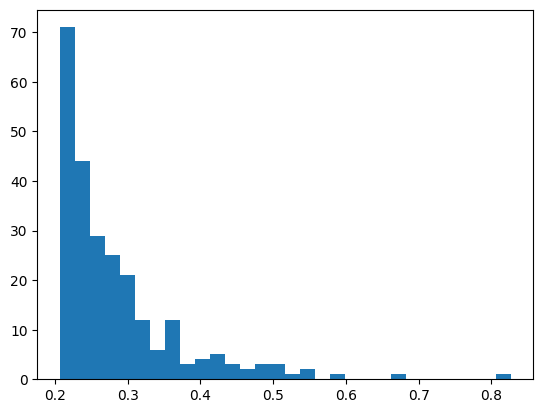

In [63]:
plt.hist(np.array(bout_lengths)/150, bins = 30)

In [8]:
np.shape(beh_class)

(319, 1500)

In [7]:
transform_class = np.zeros((1914, np.shape(beh_class)[1]))

cnt = 0 
for j in range(len(beh_class)): 
    rep_class = np.tile(beh_class[j], [6,1])
    transform_class[cnt:cnt+6,:] = rep_class 
    cnt+=6 

In [8]:
# Filter time-aligned arrays, separated by leg 

filter_velocity = copy.deepcopy(x_vel)  # deep copy makes an uncoupled copy of time-aligned arrays 
filter_stance = copy.deepcopy(y_stance) 
filter_swing = copy.deepcopy(y_swing)
filter_amp = copy.deepcopy(y_amp)
filter_step_freq = copy.deepcopy(y_step_freq) 
filter_heading = copy.deepcopy(y_heading)
filter_nlegs_stance = copy.deepcopy(y_nlegs_stance)
filter_step_phase = copy.deepcopy(y_step_phase) 
filter_relative_distance = copy.deepcopy(y_relative_distance) 

# something here is messing up the number of steps !!!!! 

for idx in range(len(filter_amp)):
    filter_amp[idx, transform_class[idx,:]==0] = np.nan
    filter_stance[idx, transform_class[idx,:]==0] = np.nan
    filter_swing[idx, transform_class[idx,:]==0] = np.nan
    filter_step_freq[idx, transform_class[idx,:]==0] = np.nan
    filter_heading[idx, transform_class[idx,:]==0] = np.nan
    filter_nlegs_stance[idx, transform_class[idx,:]==0] = np.nan
    filter_step_phase[idx, transform_class[idx,:]==0] = np.nan
    filter_relative_distance[idx, transform_class[idx,:]==0] = np.nan
            
l1_idx = np.arange(3, len(x_vel), 6) 

for fly in range(0, len(x_vel)): 
    for frames in range(0, x_vel.shape[1] -1):      
        # filter out outlier / tracking errors 
        if y_step_freq[fly][frames] >= 20 or \
            y_swing[fly][frames] >= 0.075 or \
            y_swing[fly][frames] <= 0.02 or \
            y_stance[fly][frames] > 0.2 or \
            y_stance[fly][frames] <= 0.02 or \
            x_vel[fly][frames] <= 2.25 or \
            y_amp[fly][frames] >= 2: 

                filter_amp[fly][frames] = nan
                filter_stance[fly][frames] = nan 
                filter_swing[fly][frames] = nan
                filter_step_freq[fly][frames] = nan
                filter_heading[fly][frames] = nan
                filter_nlegs_stance[fly][frames] = nan 
                
                if fly in l1_idx: 
                    filter_step_phase[fly-3][frames] = nan 
                    filter_step_phase[fly-2][frames] = nan 
                    filter_step_phase[fly-1][frames] = nan 
                    filter_step_phase[fly][frames] = nan 
                    filter_step_phase[fly+1][frames] = nan 
                    filter_step_phase[fly+2][frames] = nan 

                    filter_relative_distance[fly-3][frames] = nan 
                    filter_relative_distance[fly-2][frames] = nan 
                    filter_relative_distance[fly-1][frames] = nan 
                    filter_relative_distance[fly][frames] = nan 
                    filter_relative_distance[fly+1][frames] = nan 
                    filter_relative_distance[fly+2][frames] = nan 

#             x_vel[fly][frames] >= 25 or \


In [9]:
# Repackage data into 3 (fly, velocity, metric) x N (frames x fly) array 
# Separate front, middle, hind legs 

# Flatten filtered, time-aligned arrays 

final_vel = x_vel.flatten() 
final_amp = filter_amp.flatten() 
final_stance = filter_stance.flatten() 
final_swing = filter_swing.flatten() 
final_step_freq = filter_step_freq.flatten() 
final_fly = z_fly.flatten() 
final_leg = z_leg.flatten() 
final_frame_idx = z_frame_idx.flatten() 
final_heading = filter_heading.flatten() 

# Identify where there are nans across all arrays and mask out nans, truncate all arrays 
# mask  = ~np.isnan(final_amp) & ~np.isnan(final_stance) & ~np.isnan(final_swing) & ~np.isnan(final_step_freq) & ~np.isnan(final_vel)

# mask = ~np.isnan(final_amp)

# Create mask to separate by front, middle, hind legs 
# t1_mask = [(final_leg[mask] == 0) | (final_leg[mask] == 3)]
# t2_mask = [(final_leg[mask] == 1) | (final_leg[mask] == 4)]
# t3_mask = [(final_leg[mask] == 2) | (final_leg[mask] == 5)]

t1_mask = [(final_leg == 0) | (final_leg == 3)]
t2_mask = [(final_leg == 1) | (final_leg == 4)]
t3_mask = [(final_leg == 2) | (final_leg == 5)]

# separate_vel = final_vel[~np.isnan(final_vel)]
# separate_amp = final_amp[~np.isnan(final_amp)]
# separate_stance = final_stance[~np.isnan(final_stance)]
# separate_swing = final_swing[~np.isnan(final_swing)]
# separate_step_freq = final_step_freq[~np.isnan(final_step_freq)]
# separate_fly = final_fly[~np.isnan(final_fly)]
# separate_leg = final_leg[~np.isnan(final_leg)]
# separate_frame_idx = final_frame_idx[~np.isnan(final_frame_idx)]
# separate_heading = final_heading[~np.isnan(final_heading)]

# Reshape arrays into 3 x N arrays (fly, velocity, metric) 

plot_step_length = []
plot_stance = [] 
plot_swing = []
plot_step_freq = [] 

# plot_step_length.append(np.asarray((separate_fly[t1_mask[0]], separate_vel[t1_mask[0]], separate_amp[t1_mask[0]])))
# plot_step_length.append(np.asarray((separate_fly[t2_mask[0]], separate_vel[t2_mask[0]], separate_amp[t2_mask[0]])))
# plot_step_length.append(np.asarray((separate_fly[t3_mask[0]], separate_vel[t3_mask[0]], separate_amp[t3_mask[0]])))
legs = [[0,3], [1,4], [2,5]]
for j in range(3):
    fly_data = np.concatenate((final_fly[(final_leg== legs[j][0])], final_fly[(final_leg == legs[j][1])]))
    vel_data = np.concatenate((final_vel[(final_leg == legs[j][0])], final_vel[(final_leg== legs[j][1])]))
    metric_data = np.concatenate((final_amp[(final_leg == legs[j][0])], final_amp[(final_leg == legs[j][1])]))
    plot_step_length.append(np.asarray((fly_data[~np.isnan(metric_data)], vel_data[~np.isnan(metric_data)], metric_data[~np.isnan(metric_data)])))

    fly_data = np.concatenate((final_fly[(final_leg== legs[j][0])], final_fly[(final_leg == legs[j][1])]))
    vel_data = np.concatenate((final_vel[(final_leg == legs[j][0])], final_vel[(final_leg== legs[j][1])]))
    metric_data = np.concatenate((final_stance[(final_leg == legs[j][0])], final_stance[(final_leg == legs[j][1])]))
    plot_stance.append(np.asarray((fly_data[~np.isnan(metric_data)], vel_data[~np.isnan(metric_data)], metric_data[~np.isnan(metric_data)])))

    fly_data = np.concatenate((final_fly[(final_leg== legs[j][0])], final_fly[(final_leg == legs[j][1])]))
    vel_data = np.concatenate((final_vel[(final_leg == legs[j][0])], final_vel[(final_leg== legs[j][1])]))
    metric_data = np.concatenate((final_swing[(final_leg == legs[j][0])], final_swing[(final_leg == legs[j][1])]))
    plot_swing.append(np.asarray((fly_data[~np.isnan(metric_data)], vel_data[~np.isnan(metric_data)], metric_data[~np.isnan(metric_data)])))

    fly_data = np.concatenate((final_fly[(final_leg== legs[j][0])], final_fly[(final_leg == legs[j][1])]))
    vel_data = np.concatenate((final_vel[(final_leg == legs[j][0])], final_vel[(final_leg== legs[j][1])]))
    metric_data = np.concatenate((final_step_freq[(final_leg == legs[j][0])], final_step_freq[(final_leg == legs[j][1])]))
    plot_step_freq.append(np.asarray((fly_data[~np.isnan(metric_data)], vel_data[~np.isnan(metric_data)], metric_data[~np.isnan(metric_data)])))

# plot_stance = [] 
# plot_stance.append(np.asarray((separate_fly[t1_mask[0]], separate_vel[t1_mask[0]], separate_stance[t1_mask[0]])))
# plot_stance.append(np.asarray((separate_fly[t2_mask[0]], separate_vel[t2_mask[0]], separate_stance[t2_mask[0]])))
# plot_stance.append(np.asarray((separate_fly[t3_mask[0]], separate_vel[t3_mask[0]], separate_stance[t3_mask[0]])))

# plot_swing = [] 
# plot_swing.append(np.asarray((separate_fly[t1_mask[0]], separate_vel[t1_mask[0]], separate_swing[t1_mask[0]])))
# plot_swing.append(np.asarray((separate_fly[t2_mask[0]], separate_vel[t2_mask[0]], separate_swing[t2_mask[0]])))
# plot_swing.append(np.asarray((separate_fly[t3_mask[0]], separate_vel[t3_mask[0]], separate_swing[t3_mask[0]])))

# plot_step_freq = [] 
# plot_step_freq.append(np.asarray((separate_fly[t1_mask[0]], separate_vel[t1_mask[0]], separate_step_freq[t1_mask[0]])))
# plot_step_freq.append(np.asarray((separate_fly[t2_mask[0]], separate_vel[t2_mask[0]], separate_step_freq[t2_mask[0]])))
# plot_step_freq.append(np.asarray((separate_fly[t3_mask[0]], separate_vel[t3_mask[0]], separate_step_freq[t3_mask[0]])))

## note - cannot save these outputs as numpy arrays, as it is contained as a list of arrays that are different sizes. 
# either need to save unpackaged data outputs previously or find an alternative way to save 


In [101]:
np.shape(final_leg)

(2871000,)

In [102]:
np.shape(final_fly)

(2871000,)

In [94]:
final_leg[~np.isnan(final_amp)]

array([0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3., 4., 4., 4., 5., 5., 5.,
       1., 5., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4.,
       5., 5., 5., 5., 5., 5., 5., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 3., 3., 3., 4., 4., 4., 4., 4., 5., 5., 5., 0., 0., 0., 1.,
       2., 2., 3., 4., 5., 0., 0., 0., 1., 1., 2., 2., 3., 3., 4., 5., 5.,
       5., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4.,
       4., 4., 5., 5., 5., 5., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [21]:
def plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val):
    # plot parameters
    leg_colors = ['tab:blue', 'tab:orange', 'tab:green']

    # plot 1D metrics
    g = sea.JointGrid()

    for leg in range(3):
        vel_fit = np.linspace(np.min(plot_metric[leg][1]), np.max(plot_metric[leg][1]), 100)
        p = np.polyfit(plot_metric[leg][1], plot_metric[leg][2], p_coeff) # estimated coefficents...least squares polynomial fit
        y_fit = np.polyval(p, vel_fit)
        sea.lineplot(x=vel_fit, y=y_fit, color = leg_colors[leg], linewidth = 2.5, alpha =0.25, ax=g.ax_joint)

    # scatter
    if plot_scatter:
        for leg in range(3):
            if add_offset:
                offset_y = np.array([1,-1,0])[leg] * offset_val
                sea.scatterplot(x=plot_metric[leg][1], y=plot_metric[leg][2]+offset_y, color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)
            else:
                sea.scatterplot(x=plot_metric[leg][1], y=plot_metric[leg][2], color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)
                
#     # plot for each fly 
#     for leg in range(3):
#         unique_flies = np.unique(plot_metric[leg][0]).tolist()#[0:10]
#         for fly in unique_flies:
#             fly_idxs = np.where(plot_metric[leg][0]==fly)[0] 
#             vel_fit = np.linspace(np.min(plot_metric[leg][1][fly_idxs]), np.max(plot_metric[leg][1][fly_idxs]), 100)
#             p = np.polyfit(plot_metric[leg][1][fly_idxs], plot_metric[leg][2][fly_idxs], p_coeff) # estimated coefficents...least squares polynomial fit
#             y_fit = np.polyval(p, vel_fit)
#             sea.lineplot(x=vel_fit, y=y_fit, color = leg_colors[leg], linewidth = 1, alpha =0.1, ax=g.ax_joint)

    # global fits
    n_steps = np.zeros(3)
    r2_vals = np.zeros(3)
    for leg in range(3):
        n_steps[leg] = len(plot_metric[leg][1])
        vel_fit = np.linspace(np.min(plot_metric[leg][1]), np.max(plot_metric[leg][1]), 100)
        p = np.polyfit(plot_metric[leg][1], plot_metric[leg][2], p_coeff) # estimated coefficents...least squares polynomial fit
        print(p)
        y_fit = np.polyval(p, vel_fit)
        r2_vals[leg] = np.around(r2_score(plot_metric[leg][2], np.polyval(p, plot_metric[leg][1])),2)
        sea.lineplot(x=vel_fit, y=y_fit, color = leg_colors[leg], linewidth = 2.5, alpha =0.8, ax=g.ax_joint)

    # kde propability - speed and metric
    for leg in range(3):
        sea.kdeplot(x=plot_metric[leg][1], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_x, alpha = 0.5, bw_adjust = 2)
        sea.kdeplot(y=plot_metric[leg][2], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_y, alpha = 0.5, bw_adjust = 2)


    # legend and plotting parameters
    legend_text = ['Front Legs (steps = '+str(int(n_steps[0]))+', $R^{2}$ ='+ str(r2_vals[0]) + ')', 'Middle Legs (steps = '+str(int(n_steps[1]))+', $R^{2}$ ='+ str(r2_vals[1]) + ')', 'Hind Legs (steps = '+str(int(n_steps[2]))+', $R^{2}$ ='+ str(r2_vals[2]) + ')']
    g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)

    g.ax_joint.set_xlim([0,23])
    g.ax_joint.set_ylim([ylim[0],ylim[1]])
    plt.tight_layout()
    
    figure_dir = '/Users/leesuyee/Library/CloudStorage/GoogleDrive-suyeejoy@tuthill.casa/My Drive/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/fly_bowl/'
    g.savefig(figure_dir + fig_name+'.png', dpi = 200)
    g.savefig(figure_dir + fig_name+'.svg', dpi = 200)
    g.savefig(figure_dir + fig_name+'.pdf', dpi = 200)

In [21]:
len(plot_stance[2][2][~np.isnan(plot_stance[2][2])])

1115

[ 1.46712808e-05 -2.86479222e-03  7.45929643e-02]
[ 5.77027307e-05 -4.38782541e-03  8.68609060e-02]
[-5.96461942e-06 -2.11168306e-03  6.76798995e-02]


/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_40972/175201404.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


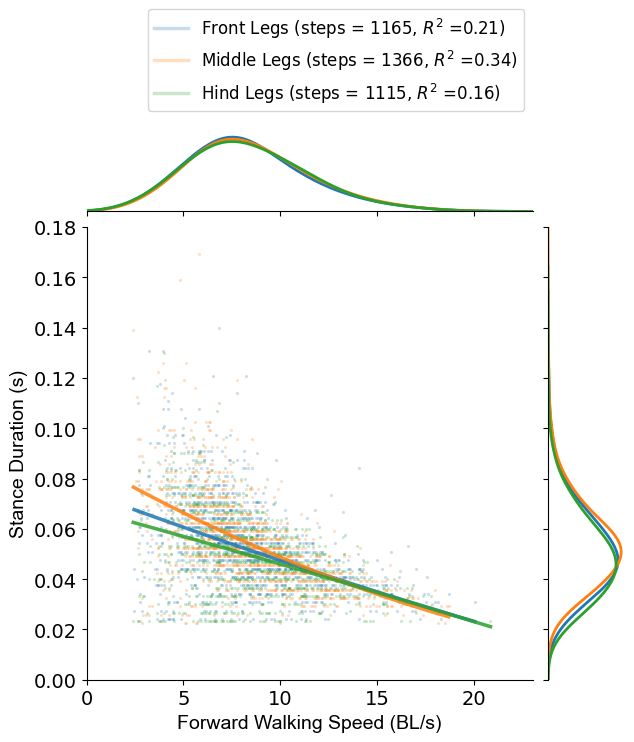

In [22]:
# plot_metric = stance 
plot_metric = plot_stance
ylabel_name = 'Stance Duration (s)'
fig_name = 'stance_duration_flybowl_us'
p_coeff = 2
plot_scatter = True
ylim = [0, 0.18]
add_offset = True
offset_val = 0.00085
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val)

[0.01145182 0.78030194]
[0.012723   0.91118259]
[0.01045356 0.81208246]


/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_40972/175201404.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


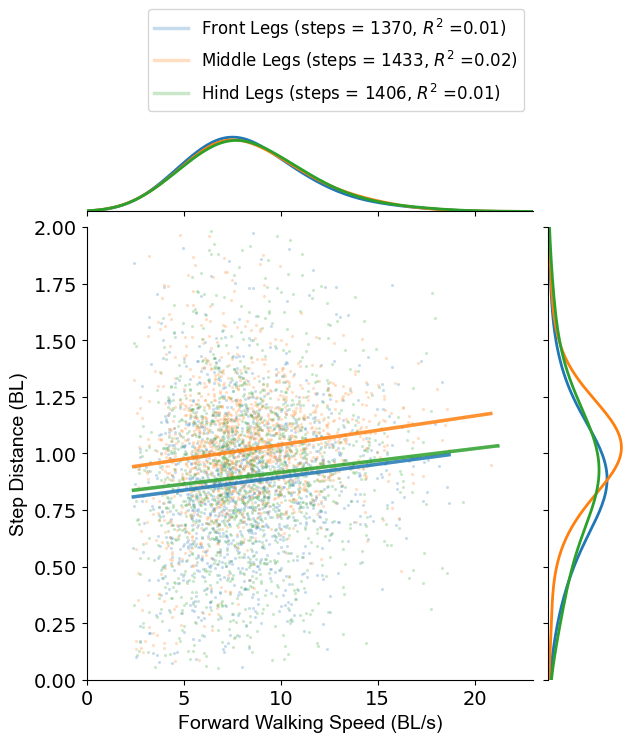

In [24]:
plot_metric = plot_step_length
ylabel_name = 'Step Distance (BL)'
fig_name = 'step_distance_flybowl_us'
p_coeff = 1
plot_scatter = True
ylim = [0, 2]
add_offset = False
offset_val = 0.0078
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val)

[-0.000725    0.04136065]
[-0.0005362   0.03855814]
[-0.00068309  0.04147134]


/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_40972/175201404.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


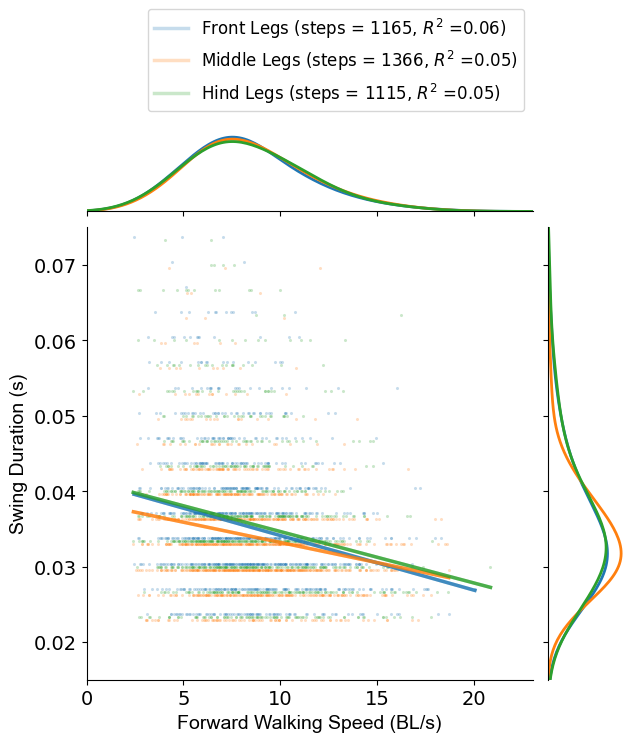

In [25]:
# plot_metric = swing 
plot_metric = plot_swing
ylabel_name = 'Swing Duration (s)'
fig_name = 'swing_duration_flybowl_us'
p_coeff = 1
plot_scatter = True
ylim = [0.015, 0.075]
add_offset = True
offset_val = 0.0004
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val)

[0.43260808 8.41208404]
[0.49990933 7.61286246]
[0.38684753 9.08259795]


/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_40972/175201404.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


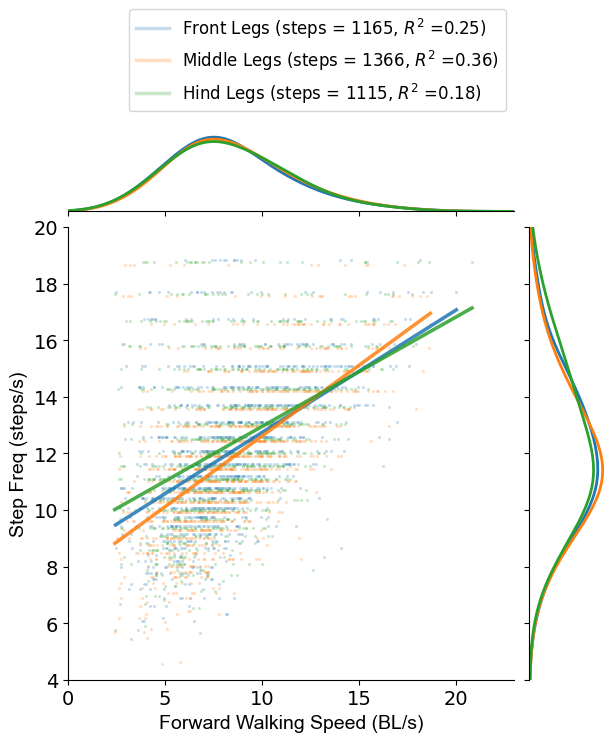

In [26]:
# plot_metric = step_freq 
plot_metric = plot_step_freq
ylabel_name = 'Step Freq (steps/s)'
fig_name = 'step_freq_flybowl_us'
p_coeff = 1
plot_scatter = True
ylim = [4, 20]
add_offset = True
offset_val = 0.075
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val)


In [27]:
# Repackage plot_metric variables for statistics 
# Output: 2 x N array - step metric, velocity code 

def metric_stats(plot_metric): 

    flybowl_metric = [] 

    t1_metric_vel = [] 
    t2_metric_vel = [] 
    t3_metric_vel = [] 

    # convert velocity to coded speed bins 
    t1_metric_vel = copy.deepcopy(plot_metric[0][1])
    t1_metric_vel[np.where(plot_metric[0][1] < 6)] = 0
    t1_metric_vel[np.where((plot_metric[0][1] >= 6) & (plot_metric[0][1] < 10))] = 1
    t1_metric_vel[np.where(plot_metric[0][1] >= 10)] = 2

    t2_metric_vel = copy.deepcopy(plot_metric[1][1])
    t2_metric_vel[np.where(plot_metric[1][1] < 6)] = 3
    t2_metric_vel[np.where((plot_metric[1][1] >= 6) & (plot_metric[1][1] < 10))] = 4
    t2_metric_vel[np.where(plot_metric[1][1] >= 10)] = 5

    t3_metric_vel = copy.deepcopy(plot_metric[2][1])
    t3_metric_vel[np.where(plot_metric[2][1] < 6)] = 6
    t3_metric_vel[np.where((plot_metric[2][1] >= 6) & (plot_metric[2][1] < 10))] = 7
    t3_metric_vel[np.where(plot_metric[2][1] >= 10)] = 8

    # repackage 
    flybowl_metric.append(np.concatenate((plot_metric[0][2], plot_metric[1][2], plot_metric[2][2])))
    flybowl_metric.append(np.concatenate((t1_metric_vel, t2_metric_vel, t3_metric_vel)))

    return np.array(flybowl_metric)


In [39]:
# Reshape plot_metrics into 2xN array for statistical comparisons across set-ups 
distance_flybowl_us = metric_stats(plot_step_length) 
stance_flybowl_us = metric_stats(plot_stance)
swing_flybowl_us = metric_stats(plot_swing)
step_freq_flybowl_us = metric_stats(plot_step_freq)

# np.save('distance_flybowl.npy', distance_flybowl_us)
# np.save('stance_flybowl.npy', stance_flybowl_us)
# np.save('swing_flybowl.npy', swing_flybowl_us)
# np.save('step_freq_flybowl.npy', step_freq_flybowl_us)

In [14]:
p = copy.deepcopy(plot_stance[2][1])
p[np.where(p <6)] = 6
p[np.where((p >= 6) & (p <10))] = 7
p[np.where(p >= 10)] = 8

In [ ]:
# # speed_dist = parallel_vel.flatten()
# # nlegs_dist = nlegs_stance_walking.flatten()

# # beh_ids = beh_class.flatten()

# # # isolate forward walking
# # fw_nlegs = nlegs_dist[beh_ids==1]
# # fw_vel = speed_dist[beh_ids==1]

# # filter nlegs - remove nans

# plot_nlegs_stance = filter_nlegs_stance.flatten() 
# plot_vel = x_vel.flatten() 

# nlegs_stance_mask = ~np.isnan(plot_nlegs_stance) & ~np.isnan(plot_vel) 

# fw_vel = plot_vel[nlegs_stance_mask]
# fw_nlegs = plot_nlegs_stance[nlegs_stance_mask]


# # edges of distributions
# vel_bins = 25
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
# vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
# nleg_cat = np.unique(fw_nlegs)

# # compute probability distribution for each of the nleg categories
# nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
# for j in range(len(nleg_cat)):
#     leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
#     for i in range(len(vel_center)):
#         nleg_vels = fw_vel[leg_idxs]
#         nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
        
# nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)


# # plot the probability of a certain number of legs in stance
# fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')

# for j in range(nleg_prob.shape[0]):
#     plt.plot(vel_center, nleg_prob[j,:], linewidth =2)

# # axis properties
# plt.xticks(fontsize = 12, fontname = 'Arial')
# plt.yticks(fontsize = 12, fontname = 'Arial')
# plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
# plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
# plt.xlim([0, 25])

# plt.legend(nleg_cat.astype(str), fontsize =12)
# plt.grid(False)
# plt.tight_layout()
# plt.show()

# # fig.savefig(figure_dir + 'nleg_stance_prob'+'.png', dpi = 200)
# # fig.savefig(figure_dir + 'nleg_stance_prob'+'.pdf', dpi = 200)

In [18]:
np.max(fw_vel)

21.189299074893643

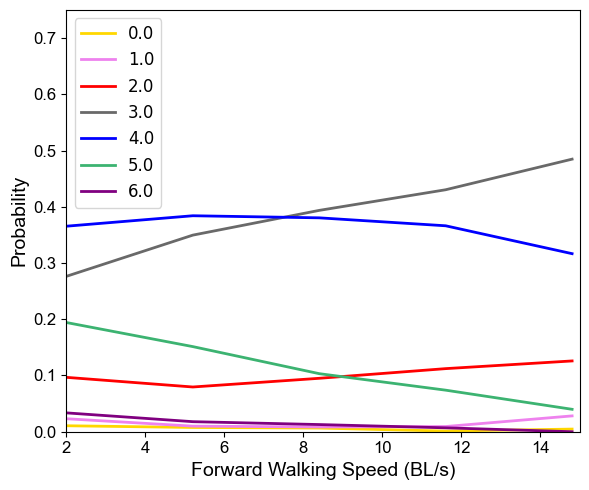

In [13]:
# speed_dist = parallel_vel.flatten()
# nlegs_dist = nlegs_stance_walking.flatten()
# beh_ids = beh_class.flatten()
# # isolate forward walking
# fw_nlegs = nlegs_dist[beh_ids==1]
# fw_vel = speed_dist[beh_ids==1]
# filter nlegs - remove nans
plot_nlegs_stance = filter_nlegs_stance.flatten() 
plot_vel = x_vel.flatten() 
nlegs_stance_mask = ~np.isnan(plot_nlegs_stance) & ~np.isnan(plot_vel) 


fw_vel = plot_vel[nlegs_stance_mask]
fw_nlegs = plot_nlegs_stance[nlegs_stance_mask]

# edges of distributions
vel_bins = 6
vel_grid = np.linspace(2, 18, vel_bins)
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
nleg_cat = np.unique(fw_nlegs)
# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
for j in range(len(nleg_cat)):
    leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
    for i in range(len(vel_center)):
        nleg_vels = fw_vel[leg_idxs]
        nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)
# plot the probability of a certain number of legs in stance
fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')
plt_colors = ['gold', 'violet', 'red', 'dimgray', 'blue', 'mediumseagreen', 'purple']
for j in range(nleg_prob.shape[0]):
    plt.plot(vel_center, nleg_prob[j,:], linewidth =2, color = plt_colors[j])
# axis properties
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
plt.xlim([2, 15])
plt.ylim([0, 0.75])
plt.legend(nleg_cat.astype(str), fontsize =12)
plt.grid(False)
plt.tight_layout()
plt.show()
# figure_dir = '/Users/leesuyee/Library/CloudStorage/GoogleDrive-suyeejoy@tuthill.casa/My Drive/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/fly_bowl/'
# fig.savefig(figure_dir + 'nleg_stance_prob'+'.png', dpi = 200)
# fig.savefig(figure_dir + 'nleg_stance_prob'+'.pdf', dpi = 200)
# fig.savefig(figure_dir + 'nleg_stance_prob'+'.svg', dpi = 200)


In [16]:
# # INPUTS FOR PHASE STUFF: 
# plot_step_phase = y_step_phase.flatten()[mask]
# plot_relative_distance = filter_relative_distance.flatten()[mask]
# plot_leg_num = z_fly.flatten()[mask]

In [33]:
l1_r1_vel = x_vel[0:-1:6,:].flatten()
l1_r2_vel = x_vel[1:-1:6,:].flatten()
l1_r3_vel = x_vel[2:-1:6,:].flatten()
l1_l2_vel = x_vel[3:-1:6,:].flatten()
l1_l3_vel = x_vel[4:-1:6,:].flatten()

In [34]:
l1_r1 = filter_step_phase[0:-1:6,:].flatten()
l1_r2 = filter_step_phase[1:-1:6,:].flatten()
l1_r3 = filter_step_phase[2:-1:6,:].flatten()
l1_l2 = filter_step_phase[3:-1:6,:].flatten()
l1_l3 = filter_step_phase[4:-1:6,:].flatten()

In [35]:
l1_r1_vel = l1_r1_vel[~np.isnan(l1_r1)]
l1_r2_vel = l1_r2_vel[~np.isnan(l1_r2)]
l1_r3_vel = l1_r3_vel[~np.isnan(l1_r3)]
l1_l2_vel = l1_l2_vel[~np.isnan(l1_l2)]
l1_l3_vel = l1_l3_vel[~np.isnan(l1_l3)]

l1_r1 = l1_r1[~np.isnan(l1_r1)]
l1_r2 = l1_r2[~np.isnan(l1_r2)]
l1_r3 = l1_r3[~np.isnan(l1_r3)]
l1_l2 = l1_l2[~np.isnan(l1_l2)]
l1_l3 = l1_l3[~np.isnan(l1_l3)]


In [36]:
l1_r1_filt_vel = l1_r1_vel[l1_r1 != -1]
l1_r2_filt_vel = l1_r2_vel[l1_r2 != -1]
l1_r3_filt_vel = l1_r3_vel[l1_r3 != -1]
l1_l2_filt_vel = l1_l2_vel[l1_l2 != -1]
l1_l3_filt_vel = l1_l3_vel[l1_l3 != -1]

l1_r1_filt = l1_r1[l1_r1 != -1]
l1_r2_filt = l1_r2[l1_r2 != -1]
l1_r3_filt = l1_r3[l1_r3 != -1]
l1_l2_filt = l1_l2[l1_l2 != -1]
l1_l3_filt = l1_l3[l1_l3 != -1]


In [37]:
l1_r1_filt = l1_r1_filt * (2 * np.pi)
l1_l2_filt = l1_l2_filt * (2 * np.pi)
l1_r3_filt = l1_r3_filt * (2 * np.pi)

l1_r2_filt = l1_r2_filt * (2 * np.pi)
l1_l3_filt = l1_l3_filt * (2 * np.pi)

l1_r2_filt = transform_half_polar(l1_r2_filt)
l1_l3_filt = transform_half_polar(l1_l3_filt)

In [38]:
relative_phase = [l1_r1_filt, l1_r2_filt,  l1_r3_filt,  l1_l2_filt,  l1_l3_filt]
phase_vel = [l1_r1_filt_vel, l1_r2_filt_vel, l1_r3_filt_vel, l1_l2_filt_vel, l1_l3_filt_vel]

slow_phase = [] 
intermed_phase = [] 
fast_phase = [] 

for j in range(0, len(relative_phase)): 
    slow_phase.append(relative_phase[j][phase_vel[j] <= 6])
    intermed_phase.append(relative_phase[j][np.logical_and(phase_vel[j] > 6, phase_vel[j] < 10)])
    fast_phase.append(relative_phase[j][phase_vel[j] >= 10])
    
    

In [92]:
len(fast_phase[0]) + len(fast_phase[1]) + len(fast_phase[2]) + len(fast_phase[3]) + len(fast_phase[4])

683

In [93]:
683/5

136.6

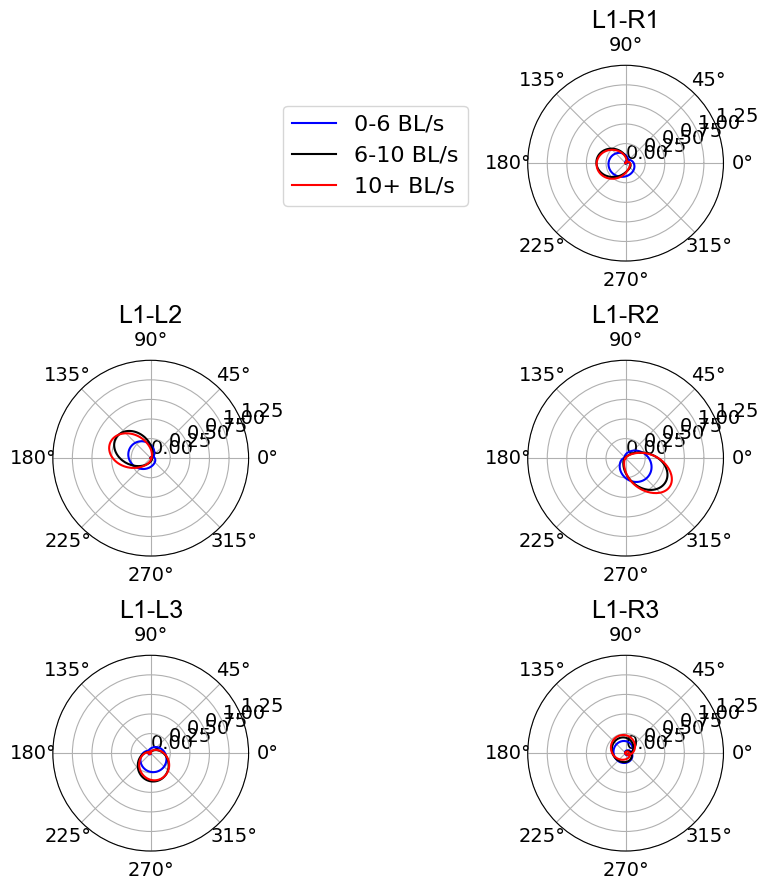

In [39]:
# plot relative phase to L1 - histograms
compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
plt_colors = ['blue', 'black', 'red']
fly_colors =['blue', 'black', 'red'] #['steelblue', 'silver', 'salmon']
plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
speed_labels = ['0-6 BL/s', '6-10 BL/s', '10+ BL/s']

fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
for p in range(len(slow_phase)):
#     for j in range(3): # walking speed bins
                
#         for fly in range(fly_phase_stats.shape[0]):
#             axs[plt_axes[p][0], plt_axes[p][1]].plot(np.array([0, fly_phase_stats[fly,0,p,j]]), np.array([0, fly_phase_stats[fly,1,p,j]]), color = fly_colors[j], linewidth = 1, zorder=1, alpha = 0.5)
        
        # plot distribution
    sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=slow_phase[p], color = plt_colors[0], linewidth = 1.5, zorder=10, label = speed_labels[0], bw_adjust=2) 
    sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=intermed_phase[p], color = plt_colors[1], linewidth = 1.5, zorder=10, label = speed_labels[1], bw_adjust=2) 
    sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=fast_phase[p], color = plt_colors[2], linewidth = 1.5, zorder=10, label = speed_labels[2], bw_adjust=2) 

    # plot parameters
    axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
    axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
#     axs[plt_axes[p][0], plt_axes[p][1]].set_ylim([0,1.15])
    axs[plt_axes[p][0], plt_axes[p][1]].set_rticks(np.arange(0,1.26,0.25))

    if p ==0:
        axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
        
axs[0,0].axis('off')
plt.tight_layout()
plt.show()

# figure_dir = '/Users/leesuyee/Library/CloudStorage/GoogleDrive-suyeejoy@tuthill.casa/My Drive/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/fly_bowl/'

# fig.savefig(figure_dir + 'L1_relative_phase_full_distribution_flybowl.png', dpi = 200)
# fig.savefig(figure_dir + 'L1_relative_phase_full_distribution_flybowl.pdf', dpi = 200)
# fig.savefig(figure_dir + 'L1_relative_phase_full_distribution_flybowl.svg', dpi = 200)

NameError: name 'phase_dists' is not defined

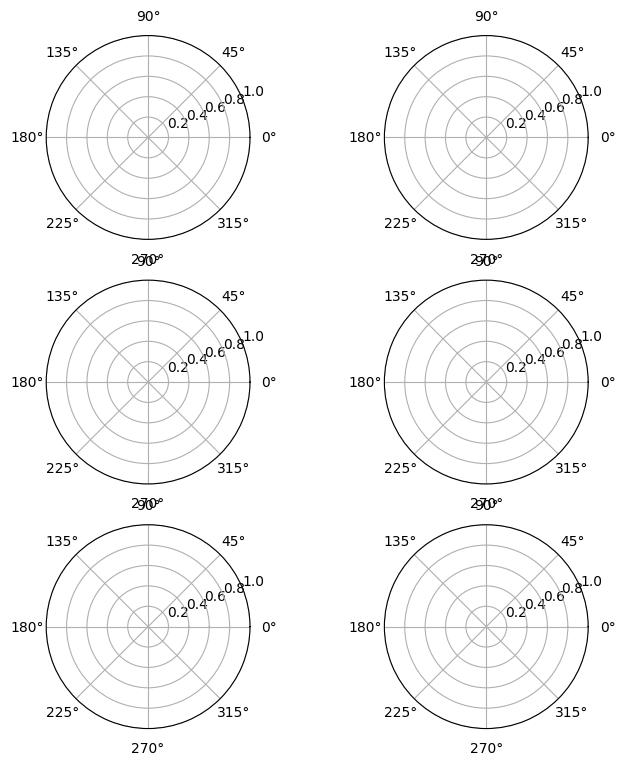

In [123]:
# # plot relative phase to L1 - histograms
# compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
# plt_colors = ['blue', 'black', 'red']
# fly_colors =['blue', 'black', 'red'] #['steelblue', 'silver', 'salmon']
# plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
# speed_labels = ['0-6 BL/s', '6-10 BL/s', '10+ BL/s']
# fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
# for p in range(phase_dists.shape[0]):
#     for j in range(3): # walking speed bins
# #         for fly in range(fly_phase_stats.shape[0]):
# #             axs[plt_axes[p][0], plt_axes[p][1]].plot(np.array([0, fly_phase_stats[fly,0,p,j]]), np.array([0, fly_phase_stats[fly,1,p,j]]), color = fly_colors[j], linewidth = 1, zorder=1, alpha = 0.5)
#         # plot distribution
#         sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=full_phase_dist[p][j], color = plt_colors[j], linewidth = 1.5, zorder=10, label = speed_labels[j], bw_adjust=2)
#     # plot parameters
#     axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
#     axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
#     axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
# #     axs[plt_axes[p][0], plt_axes[p][1]].set_ylim([0,1.2])
#     axs[plt_axes[p][0], plt_axes[p][1]].set_rticks(np.arange(0,1.26,0.25))
#     if p ==0:
#         axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
# axs[0,0].axis('off')
# plt.tight_layout()
# plt.show()
# # fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.png', dpi = 200)
# # fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.pdf', dpi = 200)
# # fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.svg', dpi = 200)


In [25]:
# calculate mean of polar distributions by transforming them into cartesian coordinates then back to polar coordinates
def estimate_ang_stats(var):
#     mean_angle = np.arctan2(np.nanmedian(np.sin(var)), np.nanmedian(np.cos(var)))
    mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
    angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
    return mean_angle, angular_dispersion

In [26]:
def compute_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(0.0,2*np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [27]:
# transform phase values to between -np.pi to np.pi
def transform_half_polar(var):
    var[var>np.pi] = var[var>np.pi] - (2*np.pi)
    return var

In [28]:
def full_distribution_transform_polar(var):
    var[var<0] = np.pi + np.abs(-np.pi - var[var<0])
    return var

In [29]:
def compute_inphase_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(-np.pi, np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [30]:
# function that transforms that space from 0 to pi to 0 to 2pi
def transform_polar(org_val):
    if org_val < 0: # only need to transform negative values to extend the space to 2pi
        transformed_val = np.pi + np.abs(-np.pi - org_val)
    else: 
        transformed_val = org_val
        
    return transformed_val

In [31]:
filter_step_phase.shape

(1914, 1500)

In [32]:
from scipy import interpolate


# notes - actual phase distributions that you want to look at are just 0:5, so need to filter out based on legs. 
# just get relative phases when legs = 0:5 and get out the rest, then reshape... 
# also need to adjust filtering all things considered... 


# relative phase distributions - to L1
relative_leg = [3, 3, 3, 3, 3] # L1-R1, L1-R2, L1-R3, L1-L2, L1-L3
inphase_comparasions = [1,4]
step_threshold = 10 # empirically determined
Nbins = 15
flies = np.unique(z_fly).astype(int).tolist()[0:10]
# flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()[0:10]
fly_phase_stats = np.zeros((len(flies), 2, len(relative_leg), 3)) # flies, phase/max_prob, phase comparasion, slow/intermediate/fast
phase_dists = np.zeros((len(relative_leg), Nbins, 2, 3)) # phases, bins, prob/centers, slow/intermediate/fast
full_phase_dist = []


# iterate through phase comparasions
for p in range(len(relative_leg)):
    for fly in flies:
# #         trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]
#         trial_idxs = np.where(z_fly == fly)[0]
#         vel_data = parallel_vel[trial_idxs,:].flatten()
#         phase_data = phase[p, :, trial_idxs].flatten()
#         beh_ids = beh_class[trial_idxs, :].flatten()
        
        # forward walking data
#         fw_vel_data = vel_data[beh_ids==1]
#         fw_phase_data = phase_data[beh_ids==1]
        fw_vel_data = x_vel.flatten()[mask]
        fw_phase_data = filter_step_phase.flatten()[mask]
        
        # filter data - remove negative 1 and nan values
        filt_vel = fw_vel_data[fw_phase_data != -1]
        filt_phase = fw_phase_data[fw_phase_data != -1]
        
        filt_vel = filt_vel[~np.isnan(filt_phase)]
        filt_phase = filt_phase[~np.isnan(filt_phase)]
        
        # split phase into the different walking speed categories - rescale from 0-1 to 0-2pi
        slow_phase = filt_phase[filt_vel<6]*(2*np.pi)
        intermediate_phase = filt_phase[np.logical_and(filt_vel>=6, filt_vel<=10)]*(2*np.pi)
        fast_phase = filt_phase[filt_vel>10]*(2*np.pi)
        
        # compute fly specific stats
        '''slow'''
        if len(slow_phase) > step_threshold:
            slow_mean, _ = estimate_ang_stats(slow_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 0] = slow_mean
                
                # distribution
                fly_slow_dist = transform_half_polar(slow_phase)
                slow_prob, slow_bin_centers = compute_inphase_histogram(fly_slow_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob)
                fly_phase_stats[fly-1, 1, p, 0] =  f(slow_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 0] = transform_polar(slow_mean)
                
                # distribution
                slow_prob, slow_bin_centers = compute_histogram(slow_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob)
                fly_phase_stats[fly-1, 1, p, 0] =  f(transform_polar(slow_mean))
                
        '''intermediate'''
        if len(intermediate_phase) > step_threshold:
            intermediate_mean, _ = estimate_ang_stats(intermediate_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 1] = intermediate_mean
                
                # distribution
                fly_intermediate_dist = transform_half_polar(intermediate_phase)
                intermediate_prob, intermediate_bin_centers = compute_inphase_histogram(fly_intermediate_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(intermediate_bin_centers, intermediate_prob)
                fly_phase_stats[fly-1, 1, p, 1] =  f(intermediate_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 1] = transform_polar(intermediate_mean)
                
                # distribution
                intermediate_prob, intermediate_bin_centers = compute_histogram(intermediate_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(intermediate_bin_centers, intermediate_prob)
                fly_phase_stats[fly-1, 1, p, 1] =  f(transform_polar(intermediate_mean))
                
        '''fast'''
        if len(fast_phase) > step_threshold:
            fast_mean, _ = estimate_ang_stats(fast_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 2] = fast_mean
                
                # distribution
                fly_fast_dist = transform_half_polar(fast_phase)
                fast_prob, fast_bin_centers = compute_inphase_histogram(fly_fast_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(fast_bin_centers, fast_prob)
                fly_phase_stats[fly-1, 1, p, 2] =  f(fast_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 2] = transform_polar(fast_mean)
                
                # distribution
                fast_prob, fast_bin_centers = compute_histogram(fast_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(fast_bin_centers, fast_prob)
                fly_phase_stats[fly-1, 1, p, 2] =  f(transform_polar(fast_mean))
                
                
        # Concatenate distributions
        cat_slow = [] 
        cat_intermediate = [] 
        cat_fast = [] 
    
        if fly == 1:
            if p in inphase_comparasions:
                cat_slow = transform_half_polar(slow_phase)
                cat_intermediate = transform_half_polar(intermediate_phase)
                cat_fast = transform_half_polar(fast_phase)
            else:
                cat_slow = slow_phase
                cat_intermediate = intermediate_phase
                cat_fast = fast_phase
        else:
            if p in inphase_comparasions:
                cat_slow = np.concatenate((cat_slow, transform_half_polar(slow_phase)))
                cat_intermediate = np.concatenate((cat_intermediate, transform_half_polar(intermediate_phase)))
                cat_fast = np.concatenate((cat_fast, transform_half_polar(fast_phase)))
            else:
                cat_slow = np.concatenate((cat_slow, slow_phase))
                cat_intermediate = np.concatenate((cat_intermediate, intermediate_phase))
                cat_fast = np.concatenate((cat_fast, fast_phase))
                
    # compute distrbutions
    if p in inphase_comparasions:
        slow_prob_global, slow_bin_centers_global = compute_inphase_histogram(cat_slow, Nbins)
        intermediate_prob_global, intermediate_bin_centers_global = compute_inphase_histogram(cat_intermediate, Nbins)
        fast_prob_global, fast_bin_centers_global = compute_inphase_histogram(cat_fast, Nbins)
    else:
        slow_prob_global, slow_bin_centers_global = compute_histogram(cat_slow, Nbins)
        intermediate_prob_global, intermediate_bin_centers_global = compute_histogram(cat_intermediate, Nbins)
        fast_prob_global, fast_bin_centers_global = compute_histogram(cat_fast, Nbins)
        
    phase_dists[p,:,0,0] = slow_prob_global # phases, bins, prob/centers, slow/intermediate/fast
    phase_dists[p,:,1,0] = slow_bin_centers_global
    phase_dists[p,:,0,1] = intermediate_prob_global
    phase_dists[p,:,1,1] = intermediate_bin_centers_global
    phase_dists[p,:,0,2] = fast_prob_global
    phase_dists[p,:,1,2] = fast_bin_centers_global
    
    # store full phase distributions
    full_phase_dist.append([cat_slow, cat_intermediate, cat_fast])
    



In [ ]:
# plot relative phase to L1 - histograms
compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
plt_colors = ['blue', 'black', 'red']
fly_colors =['blue', 'black', 'red'] #['steelblue', 'silver', 'salmon']
plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
speed_labels = ['0-6 BL/s', '6-10 BL/s', '10+ BL/s']

fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
for p in range(phase_dists.shape[0]):
    for j in range(3): # walking speed bins
                
        for fly in range(fly_phase_stats.shape[0]):
            axs[plt_axes[p][0], plt_axes[p][1]].plot(np.array([0, fly_phase_stats[fly,0,p,j]]), np.array([0, fly_phase_stats[fly,1,p,j]]), color = fly_colors[j], linewidth = 1, zorder=1, alpha = 0.5)
        
        # plot distribution
        sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=full_phase_dist[p][j], color = plt_colors[j], linewidth = 1.5, zorder=10, label = speed_labels[j], bw_adjust=2) 
        
    # plot parameters
    axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
    axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
    
    if p ==0:
        axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
        
axs[0,0].axis('off')
plt.tight_layout()
plt.show()

# fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.png', dpi = 200)
# fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.pdf', dpi = 200)

In [ ]:
# # Calculate Linear Regression Line for Step Length, Stance Duration, Swing Duration, Step Frequency  

# # Flatten filtered, time-aligned arrays 

# final_vel = x_vel.flatten() 
# final_amp = filter_amp.flatten() 
# final_stance = filter_stance.flatten() 
# final_swing = filter_swing.flatten() 
# final_step_freq = filter_step_freq.flatten() 
# final_fly = z_fly.flatten() 
# final_leg = z_leg.flatten() 
# final_frame_idx = z_frame_idx.flatten() 
# final_heading = filter_heading.flatten() 

# # Identify where there are nans across all arrays and mask out nans, truncate all arrays 

# mask  = ~np.isnan(final_vel) & ~np.isnan(final_amp) & ~np.isnan(final_stance) & ~np.isnan(final_swing) & \
#     ~np.isnan(final_step_freq) & ~np.isnan(final_fly )& ~np.isnan(final_leg) & ~np.isnan(final_frame_idx) &\
#     ~np.isnan(final_heading)

# # Calculate linear regression and R2 value for each step metric 

# # step length  
# n_steps_amp = np.zeros(2)
# r2_vals_amp = np.zeros(2)
# p_coeff = 1
# vel_fit_amp = np.linspace(np.min(final_vel[mask]), np.max(final_vel[mask]), 100)
# p_amp = np.polyfit(final_vel[mask], final_amp[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_amp = np.polyval(p_amp, vel_fit_amp)
# r2_vals_amp = np.around(r2_score(final_amp[mask], np.polyval(p_amp, final_vel[mask])),2)


# # swing duration 
# n_steps_swing = np.zeros(2)
# r2_vals_swing = np.zeros(2)
# p_coeff = 1
# vel_fit_swing = np.linspace(np.min(final_vel[mask]), np.max(final_vel[mask]), 100)
# p_swing = np.polyfit(final_vel[mask], final_swing[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_swing = np.polyval(p_swing, vel_fit_swing)
# r2_vals_swing = np.around(r2_score(final_swing[mask], np.polyval(p_swing, final_vel[mask])),2)

# # stance duration 
# n_steps_stance = np.zeros(2)
# r2_vals_stance = np.zeros(2)
# p_coeff = 2
# vel_fit_stance = np.linspace(np.min(final_vel[mask]), np.max(final_vel[mask]), 100)
# p_stance = np.polyfit(final_vel[mask], final_stance[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_stance = np.polyval(p_stance, vel_fit_stance)
# r2_vals_stance = np.around(r2_score(final_stance[mask], np.polyval(p_stance, final_vel[mask])),2)

# # step frequency 
# n_steps_step_freq = np.zeros(2)
# r2_vals_step_freq = np.zeros(2)
# p_coeff = 1
# vel_fit_step_freq = np.linspace(np.min(final_vel[mask]), np.max(final_vel[mask]), 100)
# p_step_freq = np.polyfit(final_vel[mask], final_step_freq[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_step_freq = np.polyval(p_step_freq, vel_fit_step_freq)
# r2_vals_step_freq = np.around(r2_score(final_step_freq[mask], np.polyval(p_step_freq, final_vel[mask])),2)



In [ ]:
# # Plot step metric distributions with linear regression 

# alphanum = 0.1

# plt.figure(1) 
# plt.scatter(final_vel[mask], final_amp[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_amp, y_fit_amp, color = 'black')
# plt.ylabel('swing distance (mm)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_amp)], fontsize = 12)

# plt.figure(2) 
# plt.scatter(final_vel[mask], final_stance[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_stance, y_fit_stance, color = 'black')
# plt.ylabel('stance duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 0.2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_stance)], fontsize = 12)

# plt.figure(3) 
# plt.scatter(final_vel[mask], final_swing[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_swing, y_fit_swing, color = 'black')
# plt.ylabel('swing duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 0.1])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_swing)], fontsize = 12)


# plt.figure(4) 
# plt.scatter(final_vel[mask], final_step_freq[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_step_freq, y_fit_step_freq, color = 'black')
# plt.ylabel('step freq (steps/s)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 20])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_step_freq)], fontsize = 12)

In [ ]:
# # For referencing fly/leg/frame index of certain data points 

# np.where(final_swing[mask] <= 0.01)
# reference = [] 

# for idx in np.where(final_swing[mask] <= 0.02)[0]: 
#     ref1 = z_fly.flatten()[mask][idx]
#     ref2 = z_leg.flatten()[mask][idx]
#     ref3 = z_frame_idx.flatten()[mask][idx] 
#     reference.append([ref1, ref2, ref3])
    
    
# # output structure: 
# #     time_aligned =  { "video_names" : [video_names], 
# #                   "velocity" : [velocity], # velocity[0][num_flies]
# #                   "step_amplitudes" : [step_amplitudes], # step_amplitudes[0][0][legs][num_flies]
# #                   "stance_durations" : [stance_durations], 
# #                   "swing_durations" : [swing_durations], 
# #                   "rot vel" : [rot vel], # rot_vel[0][num_flies]
# #                   "step_frequencies" : [step_frequencies],
# #                   "tripod_coord" : [tripod_coord]} 

# fly = 1
# leg = 5
# frame = 1044

# plt.figure(1) 
# plt.plot(time_align["velocity"][0][fly])
# plt.plot(frame, time_align["velocity"][0][fly][frame], 'o')

# plt.figure(2) 
# plt.plot(time_align["step_amplitudes"][0][0][leg][fly], 'o')
# plt.xlim([1000, 1100])

# plt.figure(3)
# plt.plot(time_align["heading"][0][fly])


In [ ]:
# # Double check grouping 
# # print(len(global_variables)) # print number of files

# for videos in range(0, len(global_variables)): 
#     print(global_variables[videos][0]) # print file name 
#     print(len(global_variables[videos])) # output number of flies x 17 for each file
#     print(len(global_variables[videos]) / 17) # number of flies in the file 

In [ ]:
# alphanum = 0.1
# plt.figure(1) 
# plt.scatter(final_vel[mask], final_heading[mask], color = 'darkgrey', alpha = 0.1) 
# # plt.plot(vel_fit_step_freq, y_fit_step_freq, color = 'black')
# # plt.ylabel('step freq (steps/s)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 25])
# plt.ylim([-100, 100])

In [ ]:
# # Plot step metric distributions with linear regression 

# alphanum = 0.01

# plt.figure(1) 
# plt.scatter(x_vel, y_amp, color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_amp, y_fit_amp, color = 'black')
# plt.ylabel('swing distance (mm)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# # plt.ylim([0, 2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_amp)], fontsize = 12)

# plt.figure(2) 
# plt.scatter(x_vel, y_stance, color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_stance, y_fit_stance, color = 'black')
# plt.ylabel('stance duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# # plt.ylim([0, 0.2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_stance)], fontsize = 12)

# plt.figure(3) 
# plt.scatter(x_vel, y_swing, color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_swing, y_fit_swing, color = 'black')
# plt.ylabel('swing duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# # plt.ylim([0, 0.1])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_swing)], fontsize = 12)


# plt.figure(4) 
# plt.scatter(x_vel, y_step_freq, color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_step_freq, y_fit_step_freq, color = 'black')
# plt.ylabel('step freq (steps/s)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# # plt.ylim([0, 20])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_step_freq)], fontsize = 12)

In [ ]:
# # Filter time-aligned arrays by velocity, step metrics, heading direction 
# # Save Filtered and Time-Aligned Data 

# # filter = { "filter_amp" : [time_align["step_amplitudes"]], 
# #                    "filter_stance" : [time_align["stance_durations"]], 
# #                    "filter_swing" : [time_align["swing_durations"]] } 

# import copy 
# from numpy import nan 
# save = 1 # set to 1 for saving, otherwise 0 
# save_name = 'wtberlin_v11.npy'

# # Calculate nlegs in stance
# nlegs_stance = [] 
# swing_stance_mat_filler = [] 
# fly_counter = -1
# for video in range(len(data)): 
#     num_flies = int( len( data[ video ] ) / 17 )
#     for fly_num in range(num_flies):
#         fly_counter = fly_counter + 1 
#         swing_stance_mat_filler = data[video][5 + (fly_num * 17)] 
#         if np.isnan(swing_stance_mat_filler).any() == False:
#             nlegs_stance.append(sum(swing_stance_mat_filler))
            
#         else: 
#             nlegs_stance.append(np.nan)


# filter_amp = copy.deepcopy(time_align["step_amplitudes"]) # deep copy makes an uncoupled copy of time-aligned arrays (can make changes to one w/o affecting other)
# filter_stance = copy.deepcopy(time_align["stance_durations"])
# filter_swing = copy.deepcopy(time_align["swing_durations"])
# filter_heading = copy.deepcopy(time_align["heading"])
# filter_velocity = copy.deepcopy(time_align["velocity"])
# filter_step_freq = copy.deepcopy(time_align["step_frequencies"])
# filter_nlegs_stance = copy.deepcopy(nlegs_stance)
# filter_tcs = copy.deepcopy(time_align["tripod_coord"])

# for fly in range(0, len(time_align["velocity"][0])):  
#         for leg in range(0,6):
#             for frames in range(0, 1500): 

#                 if time_align["step_frequencies"][0][0][leg][fly][frames] >= 20 or \
#                    time_align["step_amplitudes"][0][0][leg][fly][frames] >= 1.5  or \
#                    time_align["step_amplitudes"][0][0][leg][fly][frames] <= 0.25 or \
#                    time_align["stance_durations"][0][0][leg][fly][frames] <= 0.02 or \
#                    time_align["stance_durations"][0][0][leg][fly][frames] >= 0.2 or \
#                    time_align["swing_durations"][0][0][leg][fly][frames] >= 0.075 or \
#                    time_align["swing_durations"][0][0][leg][fly][frames] <= 0.02 or \
#                    time_align["velocity"][0][fly][frames] <= 3 or \
#                    time_align["velocity"][0][fly][frames] >= 25: 
        
#                         filter_amp[0][0][leg][fly][frames] = nan
#                         filter_stance[0][0][leg][fly][frames] = nan 
#                         filter_swing[0][0][leg][fly][frames] = nan
#                         filter_step_freq[0][0][leg][fly][frames] = nan
                        
# # filter out turning conditions - short, high-frequency steps, low-mid velocity 
    
#                 elif time_align["velocity"][0][fly][frames] <= 5 and \
#                    time_align["step_frequencies"][0][0][leg][fly][frames] >= 10 and \
#                    time_align["step_amplitudes"][0][0][leg][fly][frames] < 0.5 and \
#                    time_align["stance_durations"][0][0][leg][fly][frames] <= 0.05 and \
#                    time_align["swing_durations"][0][0][leg][fly][frames] <= 0.05:
        
#                         filter_amp[0][0][leg][fly][frames] = nan
#                         filter_stance[0][0][leg][fly][frames] = nan 
#                         filter_swing[0][0][leg][fly][frames] = nan
#                         filter_step_freq[0][0][leg][fly][frames] = nan
                        
#                 elif 5 <= time_align["velocity"][0][fly][frames] <= 10 and \
#                    time_align["step_frequencies"][0][0][leg][fly][frames] >= 15 and \
#                    time_align["step_amplitudes"][0][0][leg][fly][frames] < 0.5 and \
#                    time_align["stance_durations"][0][0][leg][fly][frames] <= 0.05 and \
#                    time_align["swing_durations"][0][0][leg][fly][frames] <= 0.05:        
        
#                         filter_amp[0][0][leg][fly][frames] = nan
#                         filter_stance[0][0][leg][fly][frames] = nan 
#                         filter_swing[0][0][leg][fly][frames] = nan
#                         filter_step_freq[0][0][leg][fly][frames] = nan
            


# if save == 1: 
#     time_align_name = 'time_align_' + save_name
#     np.save(time_align_name, time_align)

#     velocity_name = save_name + '_total_velocity'
#     np.save(velocity_name, filter_velocity)

#     heading_name = save_name + '_heading_angle'
#     np.save(heading_name, filter_heading)

#     swing_distance_name = save_name + '_swing_distance'
#     np.save(swing_distance_name, filter_amp)

#     stance_duration_name = save_name + '_stance_duration'
#     np.save(stance_duration_name, filter_stance)

#     swing_duration_name = save_name + '_swing_duration'
#     np.save(swing_duration_name, filter_swing)

#     filter_step_freq_name = save_name + '_step_freq'
#     np.save(filter_step_freq_name, filter_step_freq) 

#     filter_nlegsstance_name =  save_name + '_nlegs_stance'
#     np.save(filter_nlegsstance_name, filter_nlegs_stance)

#     filter_tcs_name = save_name + '_tcs'
#     np.save(filter_tcs_name, filter_tcs)


In [ ]:
# # IS REGRESSION GETTING MESSED UP BY EXTRA VEL POINTS? 

# ## For plotting: 
# # Group Filtered Step Metric Data and Velocities (For All Legs / Flies) For Linear Regression 
# # Calculate Regression Lines 

# # input - filtered step metric list (filter_amp,  filter_stance, filter swing)
# # output - all_legs_vel and all_legs (6 rows for each fly x 1500 frames)

# # set some empty variables to fill 
# import copy 
# from scipy import stats
# from sklearn.metrics import r2_score

# copy_filter_amp = copy.deepcopy(filter_amp) # change this variable depending on what metric you want to look at 
# copy_filter_stance = copy.deepcopy(filter_stance) 
# copy_filter_swing = copy.deepcopy(filter_swing)
# copy_filter_step_freq = copy.deepcopy(filter_step_freq)
# copy_filter_tcs = copy.deepcopy(filter_tcs)
# # 
# all_legs_amp = []
# all_legs_stance = []
# all_legs_swing = []
# all_legs_step_freq = []
# all_legs_tcs = []
# all_legs_vel = []

# for fly in range(0, len(time_align["velocity"][0])): 
#     tcs_filler = np.empty([1, 1500])
#     tcs_filler[:] = np.NaN 
    
#     vel_filler = np.empty([1, 1500])
#     vel_filler[:] = np.NaN 
    
#     for frame in range(0, 1500): 
#         if np.isnan(copy_filter_tcs[0][fly][frame]) == False:
#             vel_filler[0,frame] = time_align["velocity"][0][fly][frame]
#             tcs_filler[0,frame] = copy_filter_tcs[0][fly][frame]
        
#     for leg in range(0,6):  
#         amp_filler = np.empty([1, 1500])
#         amp_filler[:] = np.NaN

#         stance_filler = np.empty([1, 1500])
#         stance_filler[:] = np.NaN

#         swing_filler = np.empty([1, 1500])
#         swing_filler[:] = np.NaN

#         stepfreq_filler = np.empty([1, 1500])
#         stepfreq_filler[:] = np.NaN
        
#         for frame in range(0, 1500): 
#             if np.isnan(copy_filter_amp[0][0][leg][fly][frame]) == False: #identify non-nan indices in velocity and step metric  
#                 vel_filler[0,frame] = time_align["velocity"][0][fly][frame]
#                 amp_filler[0,frame] = copy_filter_amp[0][0][leg][fly][frame]
                
#             if np.isnan(copy_filter_stance[0][0][leg][fly][frame]) == False:
#                 vel_filler[0,frame] = time_align["velocity"][0][fly][frame]
#                 stance_filler[0,frame] = copy_filter_stance[0][0][leg][fly][frame]
                
#             if np.isnan(copy_filter_swing[0][0][leg][fly][frame]) == False:
#                 vel_filler[0,frame] = time_align["velocity"][0][fly][frame]
#                 swing_filler[0,frame] = copy_filter_swing[0][0][leg][fly][frame]
                
#             if np.isnan(copy_filter_step_freq[0][0][leg][fly][frame]) == False:
#                 vel_filler[0,frame] = time_align["velocity"][0][fly][frame]
#                 stepfreq_filler[0,frame] = copy_filter_step_freq[0][0][leg][fly][frame]

#             else: 
#                 continue

#         all_legs_vel.extend(vel_filler) #iteratively fill rows 
#         all_legs_amp.extend(amp_filler)
#         all_legs_stance.extend(stance_filler)
#         all_legs_swing.extend(swing_filler)
#         all_legs_step_freq.extend(stepfreq_filler)
#         all_legs_tcs.extend(tcs_filler)

In [ ]:
# # is this calculating on entire thing? or just partial?? 

# # Calculate Linear Regression Line for Step Length, Swing Duration, Step Frequency  

# mask  = ~np.isnan(all_legs_vel) & ~np.isnan(all_legs_amp) & ~np.isnan(all_legs_stance) & ~np.isnan(all_legs_swing) & \
#     ~np.isnan(all_legs_step_freq) 
# # step duration 
# n_steps_amp = np.zeros(2)
# r2_vals_amp = np.zeros(2)
# p_coeff = 1
# x_amp = np.array(all_legs_vel)
# y_amp = np.array(all_legs_amp)
# # mask_amp = ~np.isnan(x_amp) & ~np.isnan(y_amp)
# vel_fit_amp = np.linspace(np.min(x_amp[mask]), np.max(x_amp[mask]), 100)
# p_amp = np.polyfit(x_amp[mask], y_amp[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_amp = np.polyval(p_amp, vel_fit_amp)
# r2_vals_amp = np.around(r2_score(y_amp[mask], np.polyval(p_amp, x_amp[mask])),2)


# n_steps_swing = np.zeros(2)
# r2_vals_swing = np.zeros(2)
# p_coeff = 1
# x_swing = np.array(all_legs_vel)
# y_swing = np.array(all_legs_swing)
# # mask_swing = ~np.isnan(x_swing) & ~np.isnan(y_swing)
# vel_fit_swing = np.linspace(np.min(x_swing[mask]), np.max(x_swing[mask]), 100)
# p_swing = np.polyfit(x_swing[mask], y_swing[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_swing = np.polyval(p_swing, vel_fit_swing)
# r2_vals_swing = np.around(r2_score(y_swing[mask], np.polyval(p_swing, x_swing[mask])),2)

# n_steps_stance = np.zeros(2)
# r2_vals_stance = np.zeros(2)
# p_coeff = 2
# x_stance = np.array(all_legs_vel)
# y_stance = np.array(all_legs_stance)
# # mask_stance = ~np.isnan(x_stance) & ~np.isnan(y_stance)
# vel_fit_stance = np.linspace(np.min(x_stance[mask]), np.max(x_stance[mask]), 100)
# p_stance = np.polyfit(x_stance[mask], y_stance[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_stance = np.polyval(p_stance, vel_fit_stance)
# r2_vals_stance = np.around(r2_score(y_stance[mask], np.polyval(p_stance, x_stance[mask])),2)


# n_steps_step_freq = np.zeros(2)
# r2_vals_step_freq = np.zeros(2)
# p_coeff = 1
# x_step_freq = np.array(all_legs_vel)
# y_step_freq = np.array(all_legs_step_freq)
# # mask_step_freq = ~np.isnan(x_step_freq) & ~np.isnan(y_step_freq)
# vel_fit_step_freq = np.linspace(np.min(x_amp[mask]), np.max(x_amp[mask]), 100)
# p_step_freq = np.polyfit(x_step_freq[mask], y_step_freq[mask], p_coeff) # estimated coefficents...least squares polynomial fit
# y_fit_step_freq = np.polyval(p_step_freq, vel_fit_step_freq)
# r2_vals_step_freq = np.around(r2_score(y_step_freq[mask], np.polyval(p_step_freq, x_step_freq[mask])),2)

# # n_steps_tcs = np.zeros(2)
# # r2_vals_tcs = np.zeros(2)
# # x_tcs = np.array(all_legs_vel)
# # y_tcs = np.array(all_legs_tcs)
# # p_coeff = 1
# # mask_tcs = ~np.isnan(x_tcs) & ~np.isnan(y_tcs)
# # vel_fit_tcs = np.linspace(np.min(x_amp[mask_tcs]), np.max(x_tcs[mask_tcs]), 100)
# # p_tcs = np.polyfit(x_tcs[mask_tcs], y_tcs[mask_tcs], p_coeff) # estimated coefficents...least squares polynomial fit
# # y_fit_tcs = np.polyval(p_tcs, vel_fit_tcs)
# # r2_vals_tcs = np.around(r2_score(y_tcs[mask_tcs], np.polyval(p_tcs, x_tcs[mask_tcs])),2)


In [ ]:
# alphanum = 0.01

# plt.figure(1) 
# plt.scatter(x_amp[mask], y_amp[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_amp, y_fit_amp, color = 'black')
# plt.ylabel('swing distance (mm)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_amp)], fontsize = 12)

# plt.figure(2) 
# plt.scatter(x_amp[mask], y_stance[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_stance, y_fit_stance, color = 'black')
# plt.ylabel('stance duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 0.2])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_stance)], fontsize = 12)

# plt.figure(3) 
# plt.scatter(x_amp[mask], y_swing[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_swing, y_fit_swing, color = 'black')
# plt.ylabel('swing duration (s) ')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 0.1])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_swing)], fontsize = 12)


# plt.figure(4) 
# plt.scatter(x_amp[mask], y_step_freq[mask], color = 'darkgrey', alpha = alphanum) 
# plt.plot(vel_fit_step_freq, y_fit_step_freq, color = 'black')
# plt.ylabel('step freq (steps/s)')
# plt.xlabel('velocity (bl/s)')
# plt.xlim([0, 30])
# plt.ylim([0, 20])

# plt.legend(['$R^{2}$ ='+ str(r2_vals_step_freq)], fontsize = 12)